<a href="https://colab.research.google.com/github/hibames/pneumonia-detection-/blob/main/Copy_of_Pneumonia_Detection_(valid_98_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
paultimothymooney_chest_xray_pneumonia_path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')
youssefbedeer_weights_path = kagglehub.dataset_download('youssefbedeer/weights')
youssefbedeer_chest_image_path = kagglehub.dataset_download('youssefbedeer/chest-image')

print('Data source import complete.')


Data source import complete.


<h3 style="color: #9AE6B4; font-size: 18px; font-weight: 500; margin-top: 18px; padding-left: 10px; border-left: 3px solid #68D391;">
    Core Data Processing Libraries
</h3>
General-purpose libraries for data manipulation, visualization, and utility functions

In [ ]:
import pandas as pd              # Data manipulation and analysis
import numpy as np               # Numerical computations and array handling
import matplotlib.pyplot as plt  # Basic plotting and visualization
import seaborn as sns            # Enhanced statistical visualizations
import os                        # Filesystem operations
import cv2                       # OpenCV for image processing
from PIL import Image            # Image handling and manipulation
from itertools import chain      # Utility for flattening iterables
# from tqdm import tqdm            # Progress bar for loops
# from tqdm.notebook import tqdm


<h3 style="color: #9AE6B4; font-size: 18px; font-weight: 500; margin-top: 18px; padding-left: 10px; border-left: 3px solid #68D391;">
    Machine Learning Utilities
</h3>
Scikit-learn tools for evaluation metrics and class weight computation


In [ ]:
from sklearn.utils.class_weight import compute_class_weight  # Balancing class weights
from sklearn.metrics import (                                # Model evaluation metrics
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split


 <h3 style="color: #9AE6B4; font-size: 18px; font-weight: 500; margin-top: 18px; padding-left: 10px; border-left: 3px solid #68D391;">
    TensorFlow/Keras Deep Learning Framework
</h3>
Core Keras imports for building, training, and evaluating neural networks


In [ ]:
from tensorflow.keras.models import load_model, Model, Sequential  # Model creation and loading
from tensorflow.keras import layers, regularizers, Model
from tensorflow.keras.optimizers import Adamax, SGD               # Optimization algorithms
from tensorflow.keras.regularizers import l2                      # Regularization for preventing overfitting
from tensorflow.keras.utils import to_categorical, plot_model     # Data preprocessing and model visualization
from tensorflow.keras.callbacks import (                          # Training callbacks
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)
from tensorflow.keras.preprocessing.image import img_to_array

<h3 style="color: #9AE6B4; font-size: 18px; font-weight: 500; margin-top: 18px; padding-left: 10px; border-left: 3px solid #68D391;">
    Image Preprocessing and Data Augmentation
</h3>
Tools for loading and augmenting image data

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory  # Dataset loading from directories
from tensorflow.keras.preprocessing.image import ImageDataGenerator     # Real-time data augmentation

<h3 style="color: #9AE6B4; font-size: 18px; font-weight: 500; margin-top: 18px; padding-left: 10px; border-left: 3px solid #68D391;">
    Pretrained Models
</h3>
Transfer learning models from Keras Applications


In [ ]:
from tensorflow.keras.applications import (                      # Classic pretrained CNN architectures
    VGG16, EfficientNetB0, InceptionV3, MobileNetV2, DenseNet121
)
from tensorflow.keras.applications.efficientnet import EfficientNetB0  # EfficientNet model

<h3 style="color: #9AE6B4; font-size: 18px; font-weight: 500; margin-top: 18px; padding-left: 10px; border-left: 3px solid #68D391;">
    Miscellaneous
</h3>
Suppress warnings for cleaner output

In [ ]:
import warnings
warnings.filterwarnings('ignore')

<h3 style="color: #9AE6B4; font-size: 18px; font-weight: 500; margin-top: 18px; padding-left: 10px; border-left: 3px solid #68D391;">
    Styling
</h3>
Set a professional style for consistency and readability


In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')  # Clean, professional aesthetic
sns.set_palette("deep")  # Subtle, professional color scheme

<div style='background-color: rgba(49, 130, 206, 0.1); border-left: 4px solid #3182CE; '>
    <h2 style="background: linear-gradient(90deg, #2A4365 0%, #2C5282 100%); color: #EBF8FF; font-size: 20px; padding: 8px 12px; border-radius: 4px; margin-top: 22px; font-weight: 500;">
    2.2. Define constants        
    </h2>
    <p style='padding-left: 20px; padding-bottom: 20px'>
    Fixed values used throughout the notebook for reproducibility and configuration
</p>
</div>


In [ ]:
H, W = 224, 224
IMG_SIZE = (H, W)                      # Standard input size for pretrained models
IMG_SHAPE = (H, W, 3)
BATCH_SIZE = 32                        # Number of samples per gradient update
EPOCHS = 10                            # Maximum training iterations
LEARNING_RATE = 0.0001                 # Initial learning rate for optimizers
CLASS_NAMES = ['NORMAL', 'PNEUMONIA']  # Example class labels pneumonia
CLASS_COUNT = len(CLASS_NAMES)

<h1 style="color: #63B3ED; font-size: 28px; font-weight: 600; padding-bottom: 8px; border-bottom: 2px solid #4299E1; margin-top: 25px;">
    3. Image Preprocessing
</h1>
make image data ready for training

<div style='background-color: rgba(49, 130, 206, 0.1); border-left: 4px solid #3182CE; '>
    <h2 style="background: linear-gradient(90deg, #2A4365 0%, #2C5282 100%); color: #EBF8FF; font-size: 20px; padding: 8px 12px; border-radius: 4px; margin-top: 22px; font-weight: 500;">
    3.1. Load data
    </h2>
    <p style='padding-left: 20px; padding-bottom: 20px'>
    load data from kaggle data sets , combine all the images in one data frame
</p>
</div>


In [ ]:
import os
import pandas as pd

# Define the base directory where your data is stored (adjust this path)
base_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/"  # e.g., "C:/pneumonia_project/data"

# List of dataset splits
splits = ["test", "train", "val"]
labels = ["NORMAL", "PNEUMONIA"]

# Initialize lists to store file paths and labels
file_paths = []
file_labels = []

# Loop through each split (train, valid, test)
for split in splits:
    split_dir = os.path.join(base_dir, split)
    # Loop through each label (normal, pneumonia)
    for label in labels:
        label_dir = os.path.join(split_dir, label)

        # Check if the directory exists
        if os.path.exists(label_dir):
            # Get all files in the label directory
            for file_name in os.listdir(label_dir):
                # Ensure it's a file (not a directory)
                if os.path.isfile(os.path.join(label_dir, file_name)):
                    # Add the full file path and corresponding label
                    file_paths.append(os.path.join(label_dir, file_name))
                    file_labels.append(label)

# Create a DataFrame with 'name' and 'label' columns
df = pd.DataFrame({
    "name": file_paths,
    "label": file_labels
})

# Optional: Save to a CSV file
df.to_csv("pneumonia_dataset.csv", index=False)
print("DataFrame saved as 'pneumonia_dataset.csv'")

DataFrame saved as 'pneumonia_dataset.csv'


In [ ]:
df.head()

,name,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL


<div style='background-color: rgba(49, 130, 206, 0.1); border-left: 4px solid #3182CE; '>
    <h2 style="background: linear-gradient(90deg, #2A4365 0%, #2C5282 100%); color: #EBF8FF; font-size: 20px; padding: 8px 12px; border-radius: 4px; margin-top: 22px; font-weight: 500;">
    3.2. Split the data
    </h2>
    <p style='padding-left: 20px; padding-bottom: 20px'>
split data into 65% <span style='font-weight:bold; color:orange'>training</span> , 20% <span style='font-weight:bold; color:orange'>validation</span> , 15% <span style='font-weight:bold; color:orange'>testing</span>
</p>
</div>




In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming your DataFrame is already created (e.g., from the previous step)
# If not, load it from the CSV:
# df = pd.read_csv("pneumonia_dataset.csv")

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# First split: 70% train, 30% remaining
train_df, temp_df = train_test_split(
    df,
    test_size=0.35,  # 30% for valid + test
    stratify=df["label"],  # Ensure label proportions are maintained
    random_state=42
)

# Second split: 20% valid, 10% test (from the original data)
# Since temp_df is 30%, we split it as 2/3 (20%) and 1/3 (10%) of original
valid_df, test_df = train_test_split(
    temp_df,
    test_size=0.4,  # 10/30 = 1/3 for test
    stratify=temp_df["label"],
    random_state=42
)

# Verify the sizes
print(f"Train set: {len(train_df)} samples ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation set: {len(valid_df)} samples ({len(valid_df)/len(df)*100:.1f}%)")
print(f"Test set: {len(test_df)} samples ({len(test_df)/len(df)*100:.1f}%)")
print(f"Total: {len(train_df) + len(valid_df) + len(test_df)} samples")


# Optional: Save the splits to CSV files
train_df.to_csv("train_split.csv", index=False)
valid_df.to_csv("valid_split.csv", index=False)
test_df.to_csv("test_split.csv", index=False)
print("\nSplits saved as 'train_split.csv', 'valid_split.csv', and 'test_split.csv'")

Train set: 3806 samples (65.0%)
Validation set: 1230 samples (21.0%)
Test set: 820 samples (14.0%)
Total: 5856 samples

Splits saved as 'train_split.csv', 'valid_split.csv', and 'test_split.csv'


<div style="margin: 30px 0; height: 2px; background: linear-gradient(90deg, #2D3748, #4299E1, #2D3748); width: 100%;"></div>

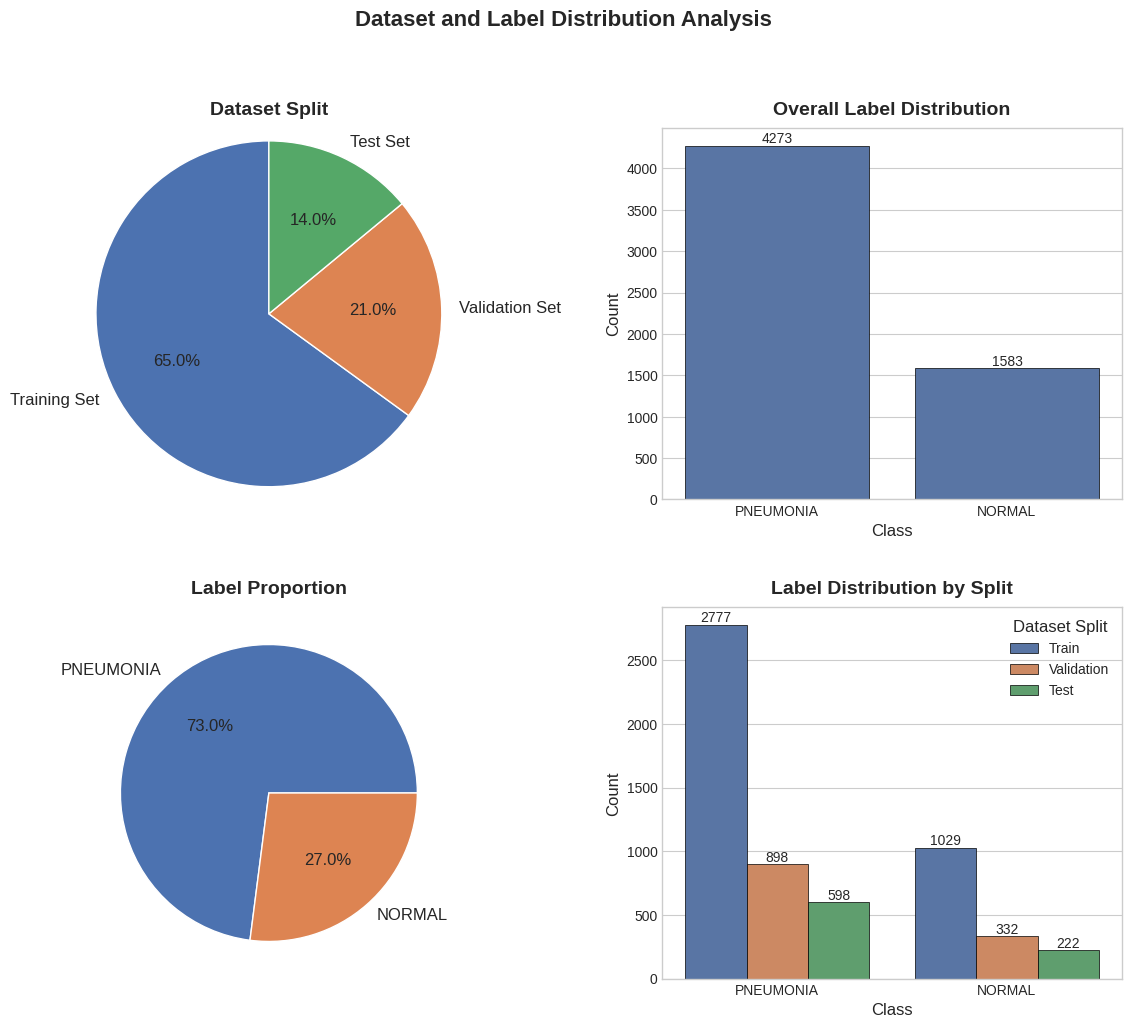

In [ ]:
# Initialize the figure with a suitable size for publication or presentation
plt.figure(figsize=(12, 10), dpi=100)

# 1. Pie Chart: Dataset Split
plt.subplot(2, 2, 1)
sizes = [len(train_df), len(valid_df), len(test_df)]
labels = ['Training Set', 'Validation Set', 'Test Set']
plt.pie(sizes, labels=labels, autopct=lambda pct: f'{pct:.1f}%', startangle=90,
        textprops={'fontsize': 12}, wedgeprops={'edgecolor': 'white', 'linewidth': 1})
plt.title('Dataset Split', fontsize=14, fontweight='bold', pad=10)
plt.axis('equal')  # Ensures circular pie chart

# 2. Bar Plot: Overall Label Distribution
plt.subplot(2, 2, 2)
ax2 = sns.countplot(x="label", data=df, edgecolor='black', linewidth=0.5)
for p in ax2.patches:
    height = p.get_height()
    if height > 0:  # Only annotate non-zero bars
        ax2.text(
            p.get_x() + p.get_width() / 2.,
            height + 0.5,
            f'{int(height)}',
            ha='center',
            va='bottom',
            fontsize=10
        )
plt.title("Overall Label Distribution", fontsize=14, fontweight='bold', pad=10)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# 3. Pie Chart: Label Proportion
plt.subplot(2, 2, 3)
df["label"].value_counts(normalize=True).plot(
    kind="pie", autopct="%1.1f%%", textprops={'fontsize': 12},
    wedgeprops={'edgecolor': 'white', 'linewidth': 1})
plt.title("Label Proportion", fontsize=14, fontweight='bold', pad=10)
plt.ylabel("")  # Remove y-label for cleaner look

# 4. Grouped Bar Plot: Label Distribution by Split
plt.subplot(2, 2, 4)
combined_df = pd.concat([
    train_df.assign(split="Train"),
    valid_df.assign(split="Validation"),
    test_df.assign(split="Test")
])

# Create the grouped bar plot
ax = sns.countplot(x="label", hue="split", data=combined_df, edgecolor='black', linewidth=0.5)

# Add numbers above each bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only annotate bars with a height (avoid empty categories)
        ax.text(
            p.get_x() + p.get_width() / 2.,  # Center of the bar (x-coordinate)
            height + 0.5,                     # Slightly above the bar (y-coordinate)
            f'{int(height)}',                 # The count as an integer
            ha='center',                      # Horizontal alignment: center
            va='bottom',                      # Vertical alignment: bottom
            fontsize=10
        )

# Customize the plot
plt.title("Label Distribution by Split", fontsize=14, fontweight='bold', pad=10)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Dataset Split", title_fontsize=12, fontsize=10, loc='best')

# Adjust layout for a polished appearance
plt.tight_layout(pad=3.0)
plt.suptitle("Dataset and Label Distribution Analysis", fontsize=16, fontweight='bold', y=1.05)

# Display the plot
plt.show()



<div style='background-color: rgba(49, 130, 206, 0.1); border-left: 4px solid #3182CE; '>
    <h2 style="background: linear-gradient(90deg, #2A4365 0%, #2C5282 100%); color: #EBF8FF; font-size: 20px; padding: 8px 12px; border-radius: 4px; margin-top: 22px; font-weight: 500;">
        3.3. Data Generator
    </h2>
    <p style='padding-left: 20px; padding-bottom: 20px'>
        A data generator is a tool or function in machine learning that efficiently loads, preprocesses, and feeds data (like images) to a model in small batches during training. Instead of loading an entire dataset into memory at once, it processes data on-the-fly, often applying transformations (e.g., resizing, normalization, or augmentation) to improve model performance. In your case, it would take image file paths and labels from a DataFrame (like train_df), prepare them (e.g., resize to 224x224 and scale pixel values), and deliver them in batches for training a model to classify "NORMAL" vs. "PNEUMONIA"
</p>
</div>




<h3 style="color: #9AE6B4; font-size: 18px; font-weight: 500; margin-top: 18px; padding-left: 10px; border-left: 3px solid #68D391;">
    Apply genenrator
</h3>



In [ ]:
# Calculate optimal test batch size
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size
print(f"Test data length: {ts_length}, Test batch size: {test_batch_size}, Test steps: {test_steps}")


# Data generators
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(
    train_df, x_col='name', y_col='label', target_size=IMG_SIZE,
    class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=BATCH_SIZE
)
valid_gen = ts_gen.flow_from_dataframe(
    valid_df, x_col='name', y_col='label', target_size=IMG_SIZE,
    class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=BATCH_SIZE
)
test_gen = ts_gen.flow_from_dataframe(
    test_df, x_col='name', y_col='label', target_size=IMG_SIZE,
    class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size
)
print("Class indices:", train_gen.class_indices)

Test data length: 820, Test batch size: 41, Test steps: 20
Found 3806 validated image filenames belonging to 2 classes.
Found 1230 validated image filenames belonging to 2 classes.
Found 820 validated image filenames belonging to 2 classes.
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}


<h3 style="color: #9AE6B4; font-size: 18px; font-weight: 500; margin-top: 18px; padding-left: 10px; border-left: 3px solid #68D391;">
    Pixel values before generartor
</h3>


In [ ]:
# Get a single sample
sample_row = df[df["label"] == label].iloc[0]
img_path = sample_row["name"]

# Before generator: Load raw image
raw_img = Image.open(img_path)
if raw_img.mode != 'RGB':
    raw_img = raw_img.convert('RGB')
raw_img = raw_img.resize(IMG_SIZE, Image.Resampling.LANCZOS)  # Match generator size
raw_array = np.array(raw_img)
print(f"Before Generator (Raw Pixels, Shape: {raw_array.shape}):")
print(raw_array[0, :5, :])  # Print first row, first 5 pixels, all channels

Before Generator (Raw Pixels, Shape: (224, 224, 3)):
[[112 112 112]
 [115 115 115]
 [114 114 114]
 [121 121 121]
 [118 118 118]]


<h3 style="color: #9AE6B4; font-size: 18px; font-weight: 500; margin-top: 18px; padding-left: 10px; border-left: 3px solid #68D391;">
    Pixel values after generartor
</h3>


In [ ]:
image_batch, label_batch = next(train_gen)

# Print pixel values after generator
print(f"After Generator (Processed Pixels, Shape: {image_batch.shape}):")
print(image_batch[0, 0, :5])  # First image, first 5 rows, all columns, all channels

After Generator (Processed Pixels, Shape: (32, 224, 224, 3)):
[[10. 10. 10.]
 [10. 10. 10.]
 [10. 10. 10.]
 [10. 10. 10.]
 [ 9.  9.  9.]]


<h2 style="background: linear-gradient(90deg, #2A4365 0%, #2C5282 100%); color: #EBF8FF; font-size: 20px; padding: 8px 12px; border-radius: 4px; margin-top: 22px; font-weight: 500;">
    3.4. Visualize some images
</h2>


In [ ]:
def plot_sample_images(df, label, num_samples=3, fixed_size=(224, 224)):
    # Filter by label
    label_df = df[df["label"] == label]
    if len(label_df) == 0:
        print(f"No images found for label '{label}'")
        return

    # Sample images
    samples = label_df.sample(min(num_samples, len(label_df)))

    # Set up a simple, nice-looking figure
    plt.figure(figsize=(3 * num_samples, 4))

    # Plot each image
    for i, (idx, row) in enumerate(samples.iterrows()):
        img = Image.open(row["name"])
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = img.resize(fixed_size, Image.Resampling.LANCZOS)

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"{label} #{i + 1}", fontsize=12)
        plt.axis("off")

    plt.tight_layout()
    plt.show()





Normal Samples:


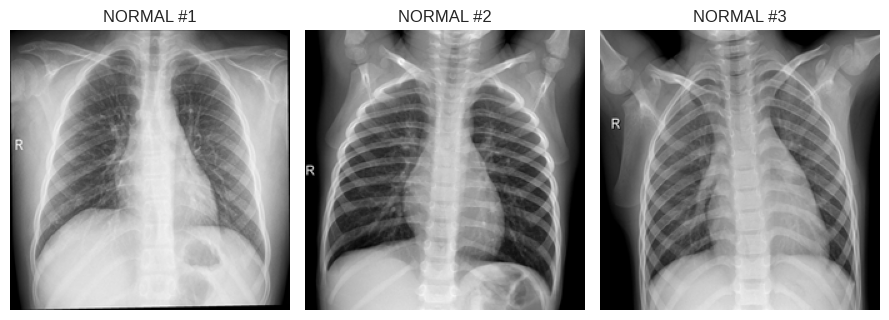


Pneumonia Samples:


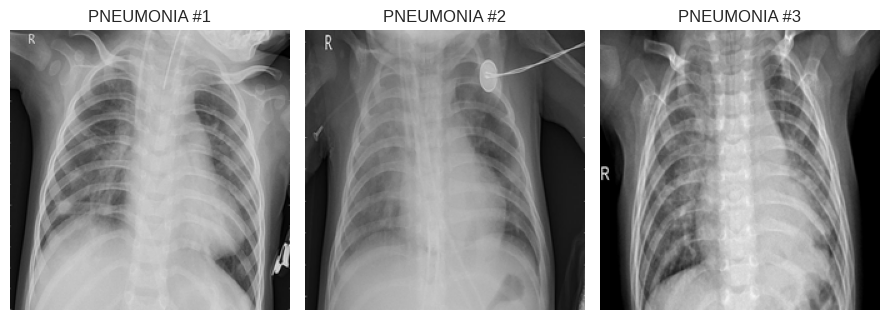

In [ ]:
print("\nNormal Samples:")
plot_sample_images(train_df, "NORMAL")

print("\nPneumonia Samples:")
plot_sample_images(train_df, "PNEUMONIA")

<div style="background-color: rgba(74, 85, 104, 0.2); border-left: 4px solid #805AD5; padding: 14px 16px; margin: 15px 0; border-radius: 3px;">
    <h3 style="font-family: 'Source Sans Pro', 'Helvetica Neue', sans-serif; color: #E9D8FD; font-size: 16px; margin: 0 0 5px 0; font-weight: 600;">Now data ready for training</h3>
</div>

<div style="margin: 30px 0; height: 2px; background: linear-gradient(90deg, #2D3748, #4299E1, #2D3748); width: 100%;"></div>

<h1 style="color: #63B3ED; font-size: 28px; font-weight: 600; padding-bottom: 8px; border-bottom: 2px solid #4299E1; margin-top: 25px;">
    4. Build the Model
</h1>
Define nedeed functions and callbacks


<div style='background-color: rgba(49, 130, 206, 0.1); border-left: 4px solid #3182CE; '>
    <h2 style="background: linear-gradient(90deg, #2A4365 0%, #2C5282 100%); color: #EBF8FF; font-size: 20px; padding: 8px 12px; border-radius: 4px; margin-top: 22px; font-weight: 500;">
    4.1. Callbacks
    </h2>
    <p style='padding-left: 20px; padding-bottom: 20px'>
</p>
</div>





In [ ]:
# Define callbacks
callbacks = [
    ModelCheckpoint(filepath='/kaggle/working/best_model_V2.keras', monitor='val_accuracy',
                    save_best_only=True, verbose=1,mode='max'),
]

<div style='background-color: rgba(49, 130, 206, 0.1); border-left: 4px solid #3182CE; '>
    <h2 style="background: linear-gradient(90deg, #2A4365 0%, #2C5282 100%); color: #EBF8FF; font-size: 20px; padding: 8px 12px; border-radius: 4px; margin-top: 22px; font-weight: 500;">
        4.2. Compute class weights with manual boost for "normal"
    </h2>
    <p style='padding-left: 20px; padding-bottom: 20px'>
    The purpose of class weights is to address class imbalance in the dataset during training. The weights are used to adjust the contribution of each class to the overall loss function and gradient calculation during backpropagation. By assigning higher weights to the minority class and lower weights to the majority class, the model gives more importance to correctly classifying instances from the minority class.
</p>
</div>




In [ ]:

classes = list(train_gen.class_indices.keys())
class_indices = train_gen.class_indices


y_numeric = train_df['label'].map(class_indices)

class_weights = compute_class_weight(class_weight='balanced', classes=np.array(range(len(classes))), y=y_numeric)
class_weight_dict_mapped = dict(zip(class_indices.values(), class_weights))
class_weight_dict_mapped[0] *= 1.5  # Increase by 20%


<div style='background-color: rgba(49, 130, 206, 0.1); border-left: 4px solid #3182CE; '>
    <h2 style="background: linear-gradient(90deg, #2A4365 0%, #2C5282 100%); color: #EBF8FF; font-size: 20px; padding: 8px 12px; border-radius: 4px; margin-top: 22px; font-weight: 500;">
    4.3. Visualize model performance
    </h2>
    <p style='padding-left: 20px; padding-bottom: 20px'>
</p>
</div>




In [ ]:
def plot_training_history(history, figsize=(20, 8)):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i + 1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {index_loss + 1} (val_loss={val_lowest:.4f})'
    acc_label = f'best epoch= {index_acc + 1} (val_acc={acc_highest:.4f})'

    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

<div style='background-color: rgba(49, 130, 206, 0.1); border-left: 4px solid #3182CE; '>
    <h2 style="background: linear-gradient(90deg, #2A4365 0%, #2C5282 100%); color: #EBF8FF; font-size: 20px; padding: 8px 12px; border-radius: 4px; margin-top: 22px; font-weight: 500;">
    4.4. Model Evaluation
    </h2>
    <p style='padding-left: 20px; padding-bottom: 20px'>
</p>
</div>



In [ ]:
def evaluate_model(valid_gen, model):
    y_true = []
    y_pred = []


    for images, labels in valid_gen:
        preds = model.predict(images, verbose=0)  # Suppress extra output
        batch_y_pred = np.argmax(preds, axis=1)  # Convert probabilities to class labels
        batch_y_true = np.argmax(labels, axis=1)  # Convert one-hot encoding to class labels
        y_true.extend(batch_y_true)
        y_pred.extend(batch_y_pred)

        if len(y_true) >= valid_gen.samples:  # Stop when all data is processed
            break

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Compute classification metrics
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")

    # Get class names from gen
    class_names = list(valid_gen.class_indices.keys())

    # Print classification report
    print("📊 Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    print(f"✅ Overall Accuracy: {acc*100:.4f}%")
    print(f"✅ Weighted Precision: {precision:.4f}")
    print(f"✅ Weighted Recall: {recall:.4f}")
    print(f"✅ Weighted F1-score: {f1:.4f}")

    # Compute Confusion Matrix
    cf_matrix = confusion_matrix(y_true, y_pred)

    # Plot Confusion Matrix
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')  # Hide color bar with cbar=False

    return acc, precision, recall, f1

<div style='background-color: rgba(49, 130, 206, 0.1); border-left: 4px solid #3182CE; '>
    <h2 style="background: linear-gradient(90deg, #2A4365 0%, #2C5282 100%); color: #EBF8FF; font-size: 20px; padding: 8px 12px; border-radius: 4px; margin-top: 22px; font-weight: 500;">
    4.5. Create Model
    </h2>
    <p style='padding-left: 20px; padding-bottom: 20px'>
    Build and compile a custom model using any pre-trained base from Keras Applications.
</p>
</div>




In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers, Model
from tensorflow.keras.utils import plot_model

def build_custom_model(
    base_model_class,
    img_shape,
    class_count,
    freeze_percentage=0.8,
    weights="imagenet",
    pooling="max",
    learning_rate=0.0001,
    plot_file="model_plot.png"
):
    """
    Build and compile a custom model using any pre-trained base from Keras Applications.

    Args:
        base_model_class: Keras Applications model class (e.g., tf.keras.applications.EfficientNetB0).
        img_shape: Tuple of input image shape (height, width, channels).
        class_count: Number of output classes.
        freeze_percentage: Fraction of base model layers to freeze (0 to 1, default 0.8).
        weights: Pre-trained weights to use (default "imagenet").
        pooling: Pooling method for base model (e.g., 'avg', 'max', None).
        learning_rate: Learning rate for optimizer (default 0.00001).
        plot_file: File path to save model plot (default "model_plot.png").

    Returns:
        Compiled Keras Model.
    """
    # Define input tensor
    inputs = tf.keras.Input(shape=img_shape)

    # Create pre-trained base model
    base_model = base_model_class(
        include_top=False,
        weights=weights,
        input_shape=img_shape,
        pooling=pooling
    )

    # Freeze a percentage of layers
    total_layers = len(base_model.layers)
    num_freeze = int(total_layers * freeze_percentage)
    for layer in base_model.layers[:num_freeze]:
        layer.trainable = False
    for layer in base_model.layers[num_freeze:]:
        layer.trainable = True

    # Pass input through base model
    x = base_model(inputs)

    # Add custom layers
    x = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
    x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.01),
                     activity_regularizer=regularizers.l1(0.003),
                     bias_regularizer=regularizers.l1(0.003), activation='relu')(x)
    x = layers.Dropout(rate=0.3, seed=123)(x)
    x = layers.Dense(class_count, activation='softmax')(x)

    # Create and compile the model
    model = Model(inputs=inputs, outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adamax(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Display summary and save plot
    model.summary()
    plot_model(
        model,
        to_file=plot_file,
        show_shapes=True
    )
    print(f"Model plot saved as '{plot_file}'")

    return model



<div style="background-color: rgba(74, 85, 104, 0.2); border-left: 4px solid #805AD5; padding: 14px 16px; margin: 15px 0; border-radius: 3px;">
    <h3 style="font-family: 'Source Sans Pro', 'Helvetica Neue', sans-serif; color: #E9D8FD; font-size: 16px; margin: 0 0 5px 0; font-weight: 600;">Now Time for Train Model</h3>
</div>

<h1 style="color: #63B3ED; font-size: 28px; font-weight: 600; padding-bottom: 8px; border-bottom: 2px solid #4299E1; margin-top: 25px;">
   5. Model Training
</h1>

<div style='background-color: rgba(49, 130, 206, 0.1); border-left: 4px solid #3182CE; '>
    <h2 style="background: linear-gradient(90deg, #2A4365 0%, #2C5282 100%); color: #EBF8FF; font-size: 20px; padding: 8px 12px; border-radius: 4px; margin-top: 22px; font-weight: 500;">
        5.1. VGG16
    </h2>
    <p style='padding-left: 20px; padding-bottom: 20px'>
    The VGG16 architecture consists of 16 convolutional layers with small 3x3 filters followed by max pooling layers.  It is a very simple, effective CNN model for image classification tasks.  It is a widely-used baseline for comparison benchmarkingin various image classification tasks.
</p>
</div>


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,578 (56.64 MB)

 Trainable params: 132,866 (519.01 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

Model plot saved as 'model_VGG16_plot.png'
Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.6434 - loss: 15.1592
Epoch 1: val_accuracy improved from -inf to 0.61545, saving model to /kaggle/working/best_model_V2.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 111s 815ms/step - accuracy: 0.6438 - loss: 15.1553 - val_accuracy: 0.6154 - val_loss: 17.0040
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.7812 - loss: 13.6908
Epoch 2: val_accuracy improved from 0.61545 to 0.81220, saving model to /kaggle/working/best_model_V2.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 52s 436ms/step - accuracy: 0.7812 - loss: 13.6891 - val_accuracy: 0.8122 - val_loss: 13.5293
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.8044 - loss: 12.8088
Epoch 3: val_accuracy improved from 0.81220 to 0.87317, saving model to /kaggle/working/best_model_V2.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 53s 441ms/step - accuracy: 0.8045 - loss: 12.8072 - val_accuracy: 0.8732 - val_loss: 12.3107
Ep

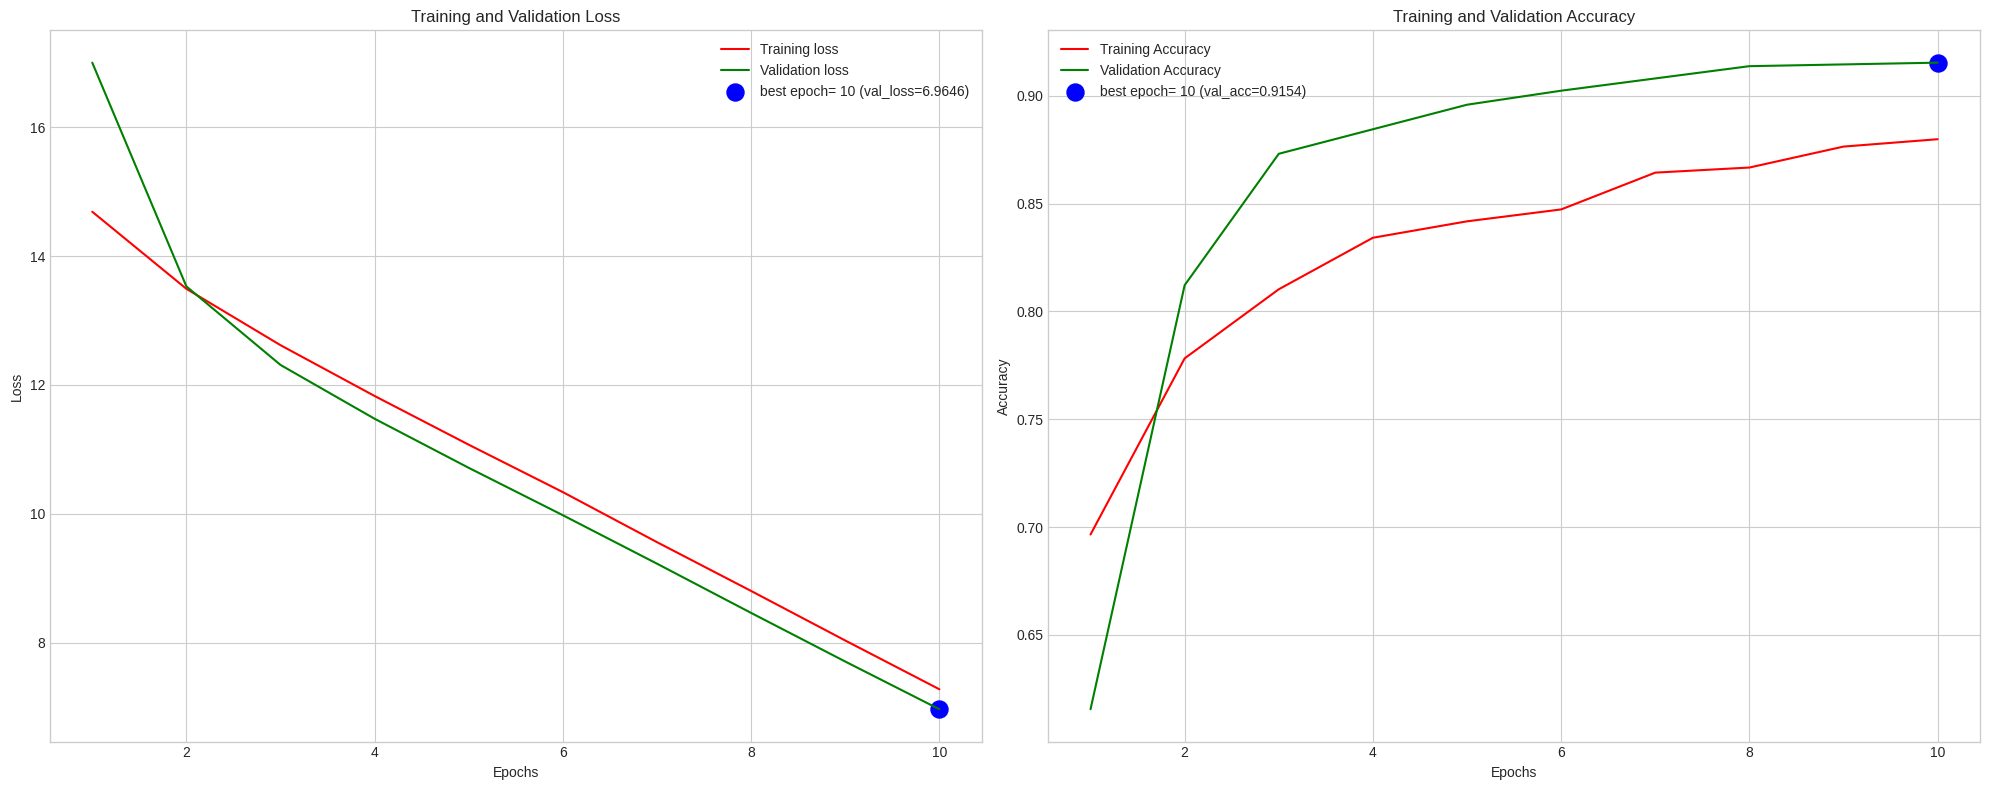

📊 Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.78      0.95      0.86       332
   PNEUMONIA       0.98      0.90      0.94       898

    accuracy                           0.92      1230
   macro avg       0.88      0.93      0.90      1230
weighted avg       0.93      0.92      0.92      1230

✅ Overall Accuracy: 91.5447%
✅ Weighted Precision: 0.9275
✅ Weighted Recall: 0.9154
✅ Weighted F1-score: 0.9179


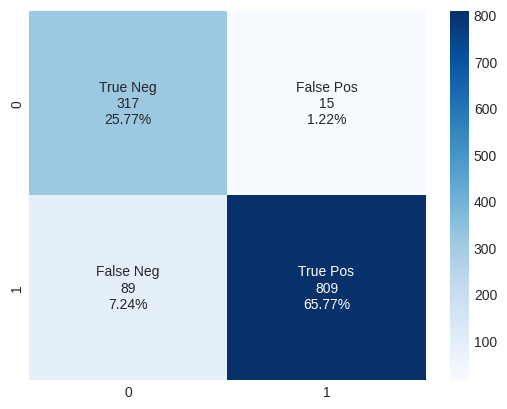

In [ ]:
# Build with VGG16
model_VGG16 = build_custom_model(
    VGG16,
    IMG_SHAPE,
    CLASS_COUNT,
    freeze_percentage=1,
    weights="imagenet",
    pooling="max",
    learning_rate=0.0001,
    plot_file="model_VGG16_plot.png"
)
history_VGG16= model_VGG16.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=EPOCHS,
    verbose=1,
    class_weight=class_weight_dict_mapped,  # استخدام class weights
    callbacks=callbacks,  # إضافة callbacks

)
plot_training_history(history_VGG16, figsize=(20, 8))

# Save model
model_VGG16.save('VGG16.keras')
model_VGG16.save('VGG16.h5')

#Evaluate model
VGG16_acc,VGG16_precision,VGG16_recall,VGG16_f1=evaluate_model(valid_gen,model_VGG16 )

<div style='background-color: rgba(49, 130, 206, 0.1); border-left: 4px solid #3182CE; '>
    <h2 style="background: linear-gradient(90deg, #2A4365 0%, #2C5282 100%); color: #EBF8FF; font-size: 20px; padding: 8px 12px; border-radius: 4px; margin-top: 22px; font-weight: 500;">
        5.2. MobileNetV2
    </h2>
    <p style='padding-left: 20px; padding-bottom: 20px'>
    The MobileNetV2 architecture is designed for efficient inference on mobile and embedded devices. It uses depthwise separable convolutions to reduce the number of parameters and computations. MobileNetV2 offers a good balance between accuracy and computational efficiency.
</p>
</div>


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,591,554 (9.89 MB)

 Trainable params: 331,010 (1.26 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

Model plot saved as 'model_MobileNetV2_plot.png'
Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.7429 - loss: 15.8372
Epoch 1: val_accuracy did not improve from 0.91545
119/119 ━━━━━━━━━━━━━━━━━━━━ 67s 478ms/step - accuracy: 0.7431 - loss: 15.8306 - val_accuracy: 0.8537 - val_loss: 17.1450
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.8099 - loss: 13.5668
Epoch 2: val_accuracy did not improve from 0.91545
119/119 ━━━━━━━━━━━━━━━━━━━━ 45s 377ms/step - accuracy: 0.8099 - loss: 13.5642 - val_accuracy: 0.8642 - val_loss: 13.0087
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8382 - loss: 12.3859
Epoch 3: val_accuracy did not improve from 0.91545
119/119 ━━━━━━━━━━━━━━━━━━━━ 46s 388ms/step - accuracy: 0.8382 - loss: 12.3840 - val_accuracy: 0.8829 - val_loss: 11.7937
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8232 - loss: 11.4642
Epoch 4: val_accuracy did not improve from 0.91545
119/119 ━━━━━━━━━━━━━━━━━

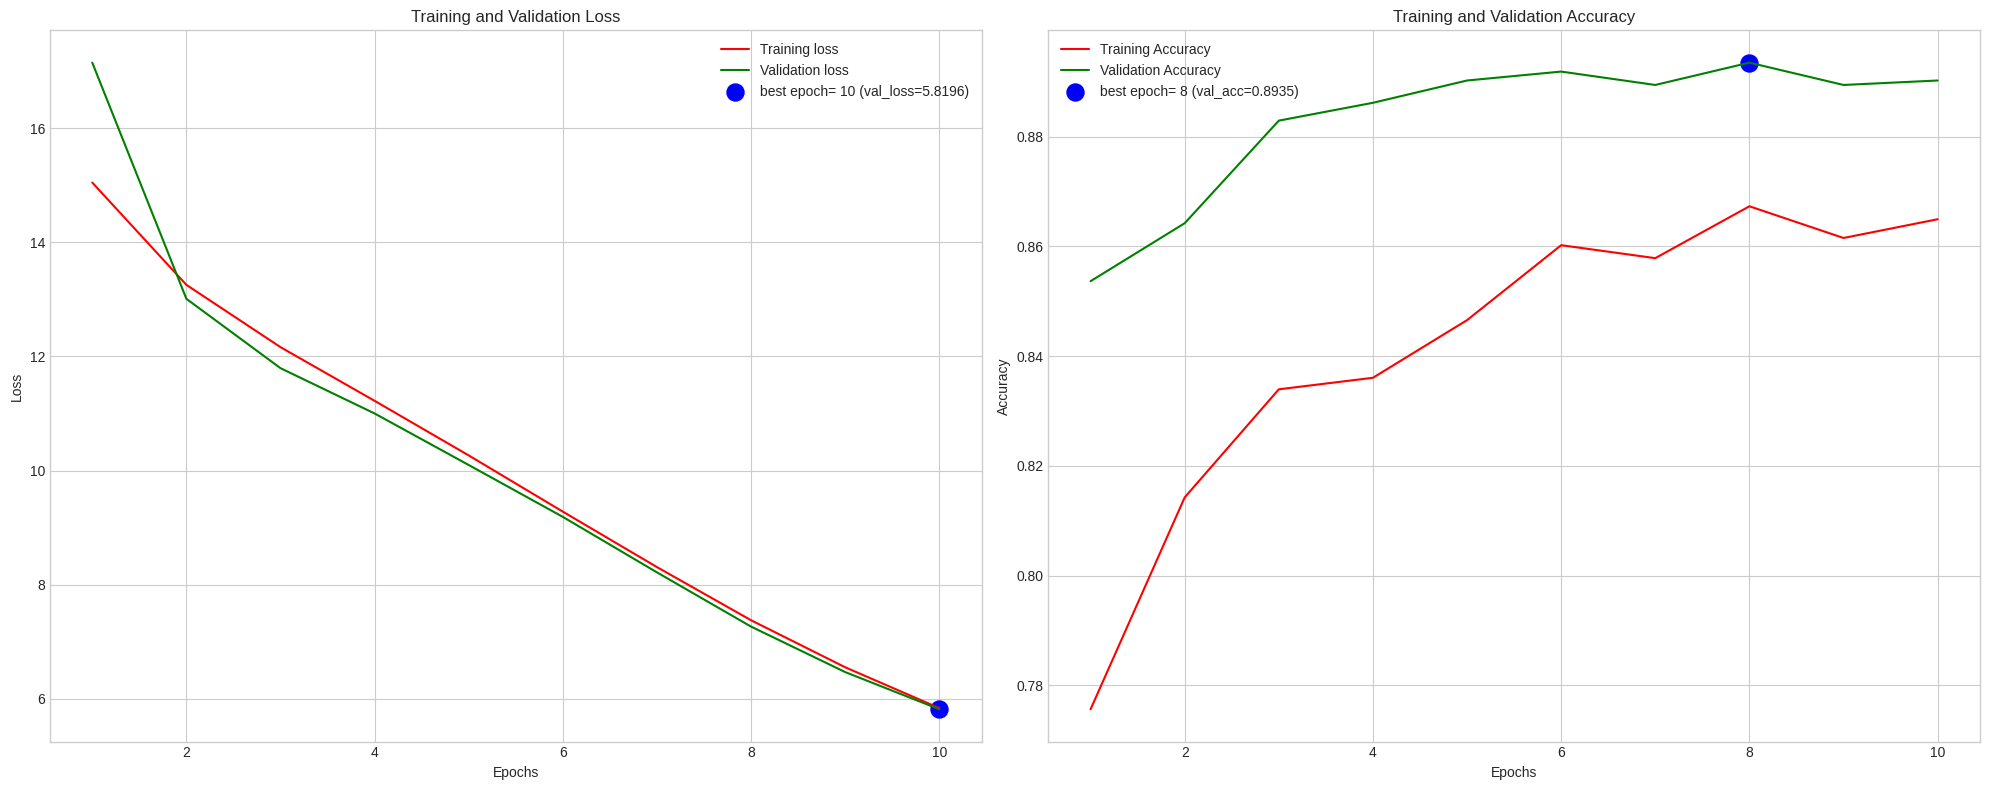

📊 Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.73      0.94      0.82       332
   PNEUMONIA       0.97      0.87      0.92       898

    accuracy                           0.89      1230
   macro avg       0.85      0.90      0.87      1230
weighted avg       0.91      0.89      0.89      1230

✅ Overall Accuracy: 89.0244%
✅ Weighted Precision: 0.9086
✅ Weighted Recall: 0.8902
✅ Weighted F1-score: 0.8940


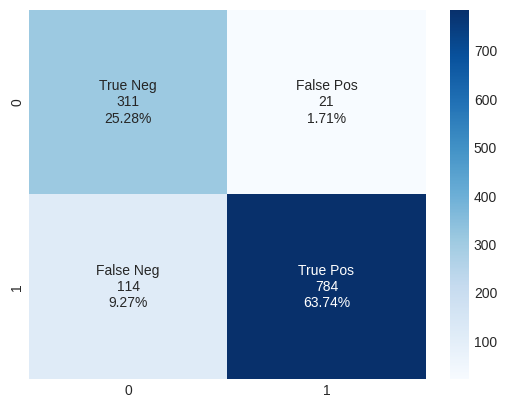

In [ ]:
# Build with MobileNetV2
model_MobileNetV2 = build_custom_model(
    MobileNetV2,
    IMG_SHAPE,
    CLASS_COUNT,
    freeze_percentage=1,
    weights="imagenet",
    pooling="max",
    learning_rate=0.0001,
    plot_file="model_MobileNetV2_plot.png"
)
history_MobileNetV2= model_MobileNetV2.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=EPOCHS,
    verbose=1,
    class_weight=class_weight_dict_mapped,  # استخدام class weights
    callbacks=callbacks,  # إضافة callbacks

)
plot_training_history(history_MobileNetV2, figsize=(20, 8))

# Save model
model_MobileNetV2.save('MobileNetV2.keras')
model_MobileNetV2.save('MobileNetV2.h5')

#Evaluate model
MobileNetV2_acc,MobileNetV2_precision,MobileNetV2_recall,MobileNetV2_f1=evaluate_model(valid_gen,model_MobileNetV2 )

<div style='background-color: rgba(49, 130, 206, 0.1); border-left: 4px solid #3182CE; '>
    <h2 style="background: linear-gradient(90deg, #2A4365 0%, #2C5282 100%); color: #EBF8FF; font-size: 20px; padding: 8px 12px; border-radius: 4px; margin-top: 22px; font-weight: 500;">
        5.3. DenseNet
    </h2>
    <p style='padding-left: 20px; padding-bottom: 20px'>
    The DenseNet architecture introduces dense connections, where each layer is connected to every other layer in a feed-forward manner. Dense connections facilitate feature reuse, promote gradient flow, and alleviate the vanishing gradient problem. DenseNet has achieved competitive results on image classification tasks and is known for its parameter efficiency.
</p>
</div>


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 1024)           │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,304,514 (27.86 MB)

 Trainable params: 264,962 (1.01 MB)

 Non-trainable params: 7,039,552 (26.85 MB)

Model plot saved as 'model_DenseNet_plot.png'
Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.6872 - loss: 14.1405
Epoch 1: val_accuracy did not improve from 0.91545
119/119 ━━━━━━━━━━━━━━━━━━━━ 110s 702ms/step - accuracy: 0.6875 - loss: 14.1346 - val_accuracy: 0.7634 - val_loss: 13.7772
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.8118 - loss: 11.9554
Epoch 2: val_accuracy did not improve from 0.91545
119/119 ━━━━━━━━━━━━━━━━━━━━ 49s 408ms/step - accuracy: 0.8119 - loss: 11.9529 - val_accuracy: 0.8211 - val_loss: 10.9027
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.8265 - loss: 10.7783
Epoch 3: val_accuracy did not improve from 0.91545
119/119 ━━━━━━━━━━━━━━━━━━━━ 49s 411ms/step - accuracy: 0.8265 - loss: 10.7758 - val_accuracy: 0.8537 - val_loss: 9.6513
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.8443 - loss: 9.6183
Epoch 4: val_accuracy did not improve from 0.91545
119/119 ━━━━━━━━━━━━━━━━━━━━ 

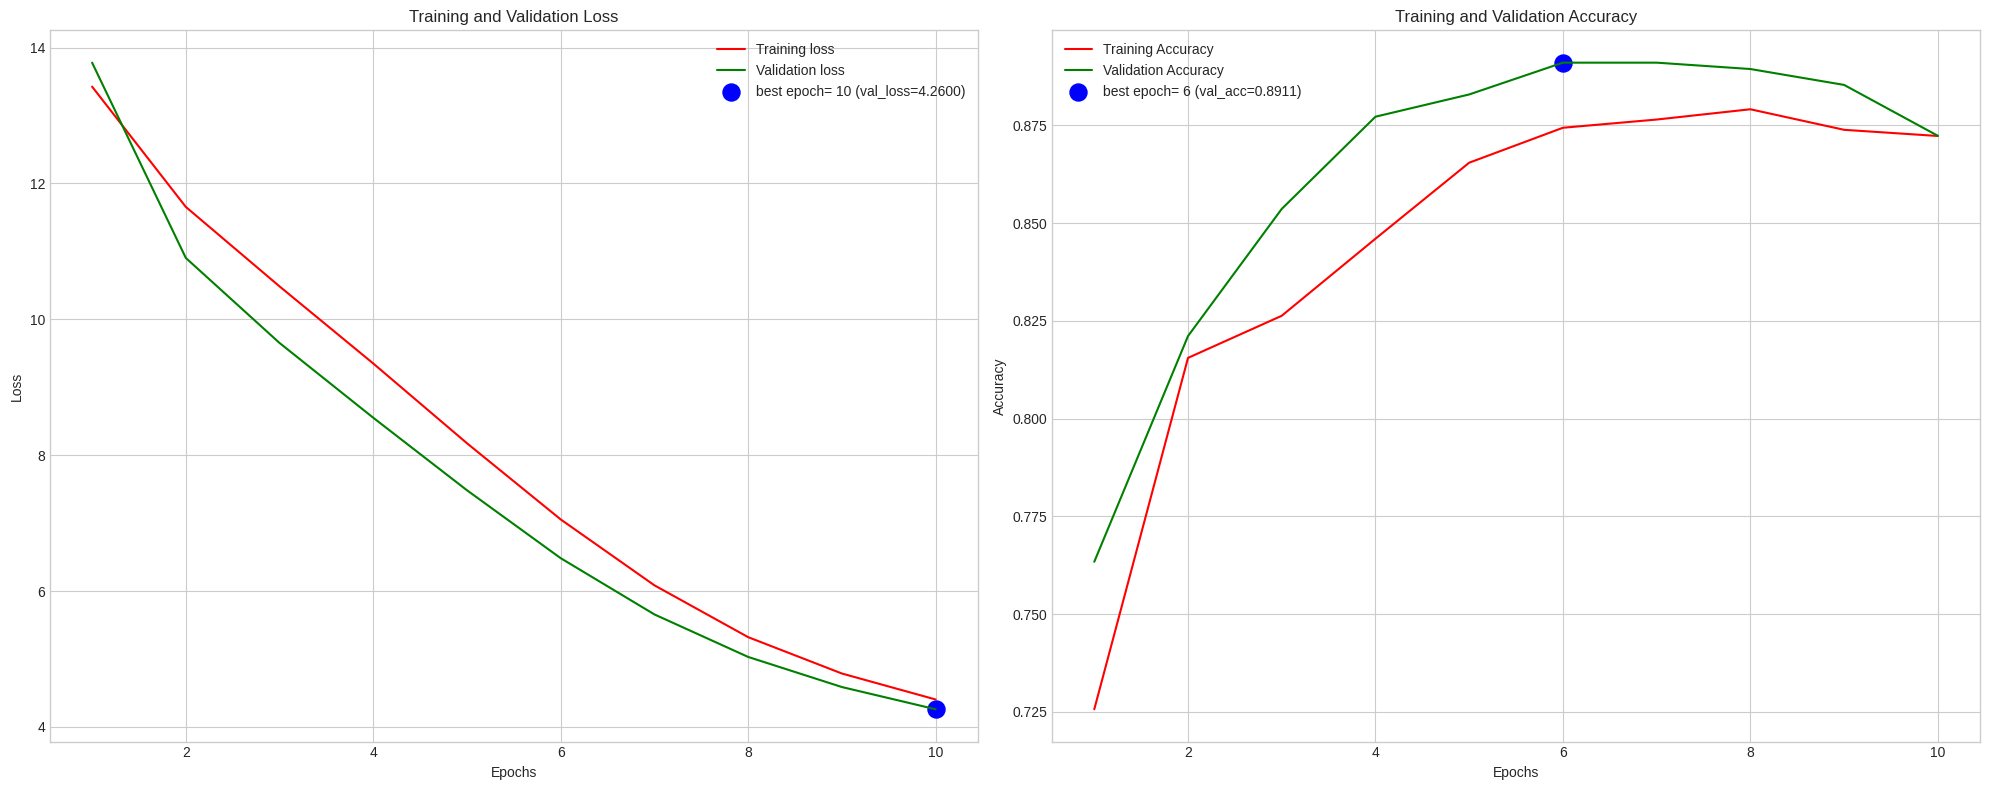

📊 Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.69      0.95      0.80       332
   PNEUMONIA       0.98      0.84      0.91       898

    accuracy                           0.87      1230
   macro avg       0.84      0.90      0.85      1230
weighted avg       0.90      0.87      0.88      1230

✅ Overall Accuracy: 87.2358%
✅ Weighted Precision: 0.9023
✅ Weighted Recall: 0.8724
✅ Weighted F1-score: 0.8777


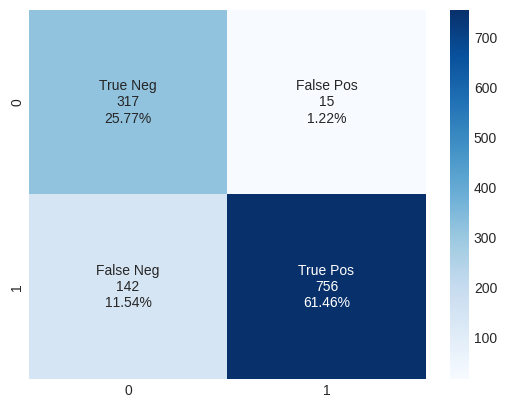

In [ ]:
# Build with DenseNet
model_DenseNet = build_custom_model(
    DenseNet121,
    IMG_SHAPE,
    CLASS_COUNT,
    freeze_percentage=1,
    weights="imagenet",
    pooling="max",
    learning_rate=0.0001,
    plot_file="model_DenseNet_plot.png"
)
history_DenseNet= model_DenseNet.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=EPOCHS,
    verbose=1,
    class_weight=class_weight_dict_mapped,  # استخدام class weights
    callbacks=callbacks,  # إضافة callbacks

)
plot_training_history(history_DenseNet, figsize=(20, 8))

# Save model
model_DenseNet.save('DenseNet.keras')
model_DenseNet.save('DenseNet.h5')

#Evaluate model
DenseNet_acc,DenseNet_precision,DenseNet_recall,DenseNet_f1=evaluate_model(valid_gen,model_DenseNet )

<div style='background-color: rgba(49, 130, 206, 0.1); border-left: 4px solid #3182CE; '>
    <h2 style="background: linear-gradient(90deg, #2A4365 0%, #2C5282 100%); color: #EBF8FF; font-size: 20px; padding: 8px 12px; border-radius: 4px; margin-top: 22px; font-weight: 500;">
        5.4. InceptionV3
    </h2>
    <p style='padding-left: 20px; padding-bottom: 20px'>
    The InceptionV3 architecture utilizes a combination of convolutional layers with different filter sizes to capture features at multiple scales. It includes the Inception module, which performs parallel convolutions with different filter sizes and concatenates their outputs. InceptionV3 has shown strong performance on image classification tasks, especially for complex datasets.
</p>
</div>


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 2048)           │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_97          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,336,034 (85.21 MB)

 Trainable params: 529,154 (2.02 MB)

 Non-trainable params: 21,806,880 (83.19 MB)

Model plot saved as 'model_InceptionV3_plot.png'
Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.6670 - loss: 14.9262
Epoch 1: val_accuracy did not improve from 0.91545
119/119 ━━━━━━━━━━━━━━━━━━━━ 86s 576ms/step - accuracy: 0.6674 - loss: 14.9142 - val_accuracy: 0.5870 - val_loss: 14.1481
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.7847 - loss: 11.4749
Epoch 2: val_accuracy did not improve from 0.91545
119/119 ━━━━━━━━━━━━━━━━━━━━ 48s 407ms/step - accuracy: 0.7848 - loss: 11.4719 - val_accuracy: 0.8106 - val_loss: 10.8269
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.8381 - loss: 10.1260
Epoch 3: val_accuracy did not improve from 0.91545
119/119 ━━━━━━━━━━━━━━━━━━━━ 50s 417ms/step - accuracy: 0.8381 - loss: 10.1237 - val_accuracy: 0.8691 - val_loss: 9.4151
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.8736 - loss: 9.0232
Epoch 4: val_accuracy did not improve from 0.91545
119/119 ━━━━━━━━━━━━━━━━━━━

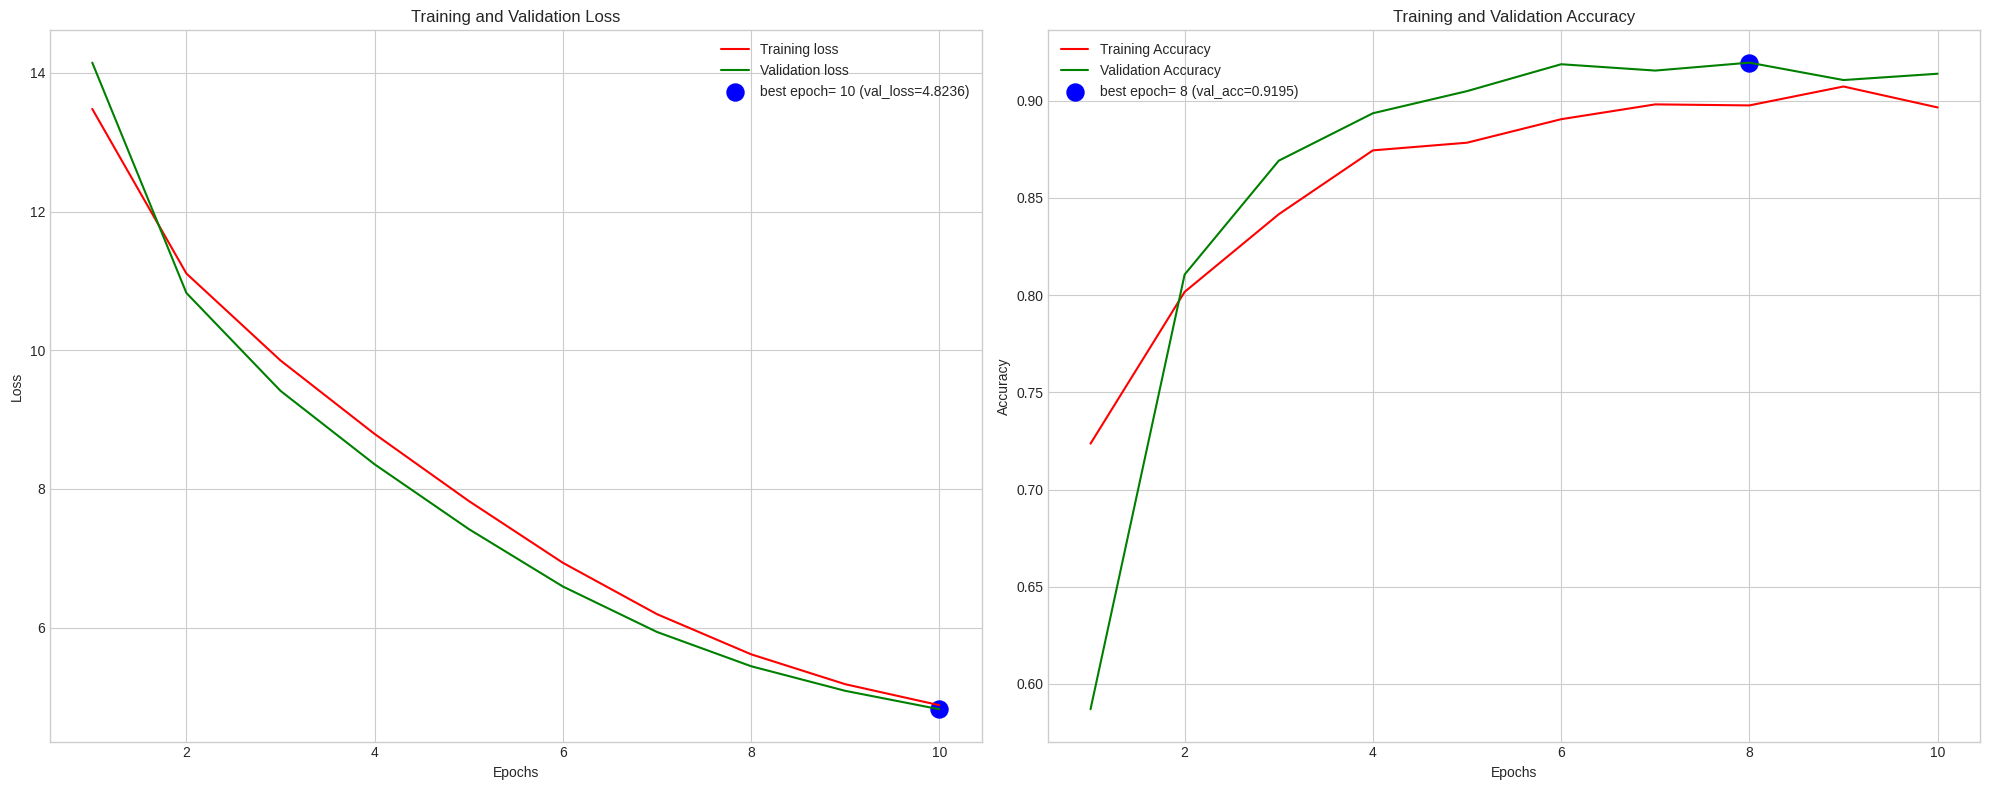

📊 Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.78      0.95      0.86       332
   PNEUMONIA       0.98      0.90      0.94       898

    accuracy                           0.91      1230
   macro avg       0.88      0.93      0.90      1230
weighted avg       0.93      0.91      0.92      1230

✅ Overall Accuracy: 91.3821%
✅ Weighted Precision: 0.9265
✅ Weighted Recall: 0.9138
✅ Weighted F1-score: 0.9163


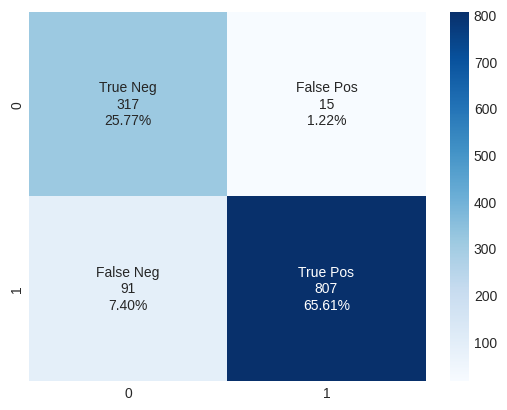

In [ ]:
# Build with InceptionV3
model_InceptionV3 = build_custom_model(
    InceptionV3,
    IMG_SHAPE,
    CLASS_COUNT,
    freeze_percentage=1,
    weights="imagenet",
    pooling="max",
    learning_rate=0.0001,
    plot_file="model_InceptionV3_plot.png"
)
history_InceptionV3= model_InceptionV3.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=EPOCHS,
    verbose=1,
    class_weight=class_weight_dict_mapped,  # استخدام class weights
    callbacks=callbacks,  # إضافة callbacks

)
plot_training_history(history_InceptionV3, figsize=(20, 8))

# Save model
model_InceptionV3.save('InceptionV3.keras')
model_InceptionV3.save('InceptionV3.h5')

#Evaluate model
InceptionV3_acc,InceptionV3_precision,InceptionV3_recall,InceptionV3_f1=evaluate_model(valid_gen,model_InceptionV3 )

<div style='background-color: rgba(49, 130, 206, 0.1); border-left: 4px solid #3182CE; '>
    <h2 style="background: linear-gradient(90deg, #2A4365 0%, #2C5282 100%); color: #EBF8FF; font-size: 20px; padding: 8px 12px; border-radius: 4px; margin-top: 22px; font-weight: 500;">
        5.5. EfficientNetB0
    </h2>
    <p style='padding-left: 20px; padding-bottom: 20px'>
    Description
</p>
</div>


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_98          │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,383,141 (16.72 MB)

 Trainable params: 331,010 (1.26 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

Model plot saved as 'model_EfficientNetB0_plot.png'
Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.7278 - loss: 16.8003
Epoch 1: val_accuracy did not improve from 0.91951
119/119 ━━━━━━━━━━━━━━━━━━━━ 89s 559ms/step - accuracy: 0.7281 - loss: 16.7938 - val_accuracy: 0.8569 - val_loss: 15.1684
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8182 - loss: 14.5645
Epoch 2: val_accuracy did not improve from 0.91951
119/119 ━━━━━━━━━━━━━━━━━━━━ 46s 389ms/step - accuracy: 0.8183 - loss: 14.5617 - val_accuracy: 0.8821 - val_loss: 13.0278
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8403 - loss: 13.3123
Epoch 3: val_accuracy did not improve from 0.91951
119/119 ━━━━━━━━━━━━━━━━━━━━ 46s 389ms/step - accuracy: 0.8404 - loss: 13.3102 - val_accuracy: 0.8862 - val_loss: 12.0146
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8643 - loss: 12.2694
Epoch 4: val_accuracy did not improve from 0.91951
119/119 ━━━━━━━━━━━━━━

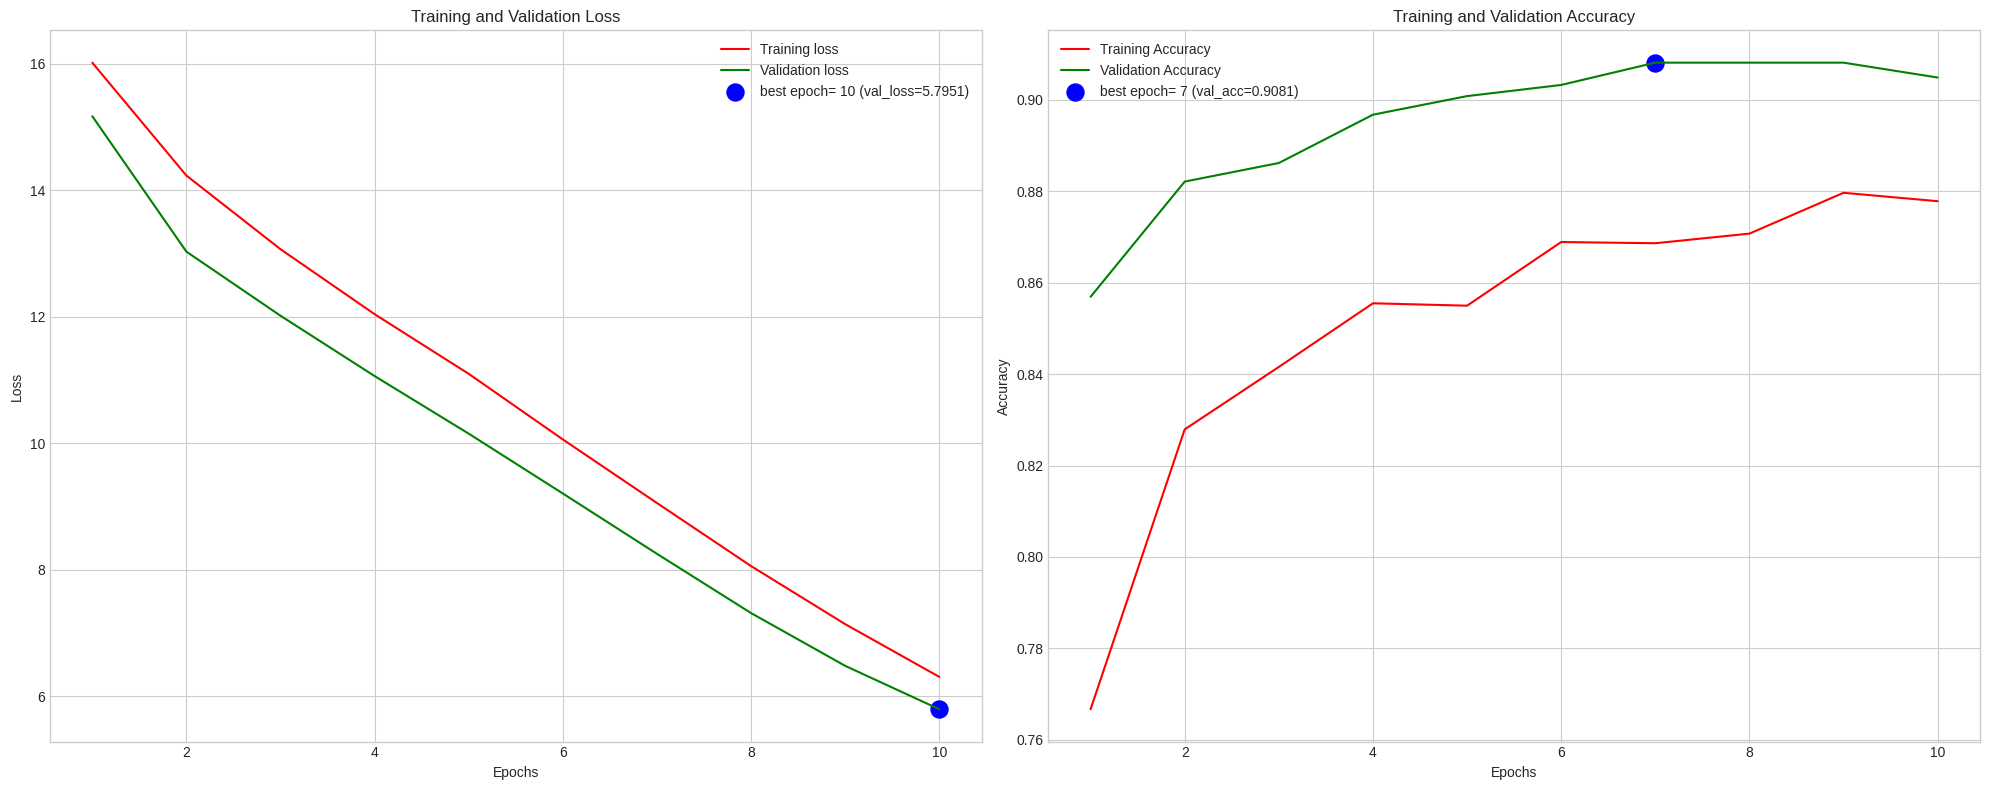

📊 Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.75      0.97      0.85       332
   PNEUMONIA       0.99      0.88      0.93       898

    accuracy                           0.90      1230
   macro avg       0.87      0.93      0.89      1230
weighted avg       0.92      0.90      0.91      1230

✅ Overall Accuracy: 90.4878%
✅ Weighted Precision: 0.9236
✅ Weighted Recall: 0.9049
✅ Weighted F1-score: 0.9082


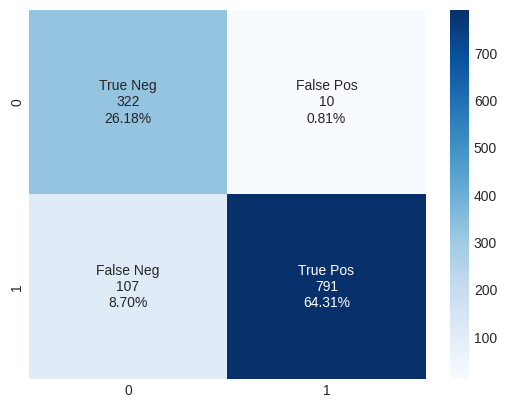

In [ ]:
# Build with EfficientNetB0
model_EfficientNetB0 = build_custom_model(
    EfficientNetB0,
    IMG_SHAPE,
    CLASS_COUNT,
    freeze_percentage=1,
    weights="imagenet",
    pooling="max",
    learning_rate=0.0001,
    plot_file="model_EfficientNetB0_plot.png"
)
history_EfficientNetB0= model_EfficientNetB0.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=EPOCHS,
    verbose=1,
    class_weight=class_weight_dict_mapped,  # استخدام class weights
    callbacks=callbacks,  # إضافة callbacks


)
plot_training_history(history_EfficientNetB0, figsize=(20, 8))

# Save model
model_EfficientNetB0.save('EfficientNetB0.keras')
model_EfficientNetB0.save('EfficientNetB0.h5')

#Evaluate model
EfficientNetB0_acc,EfficientNetB0_precision,EfficientNetB0_recall,EfficientNetB0_f1=evaluate_model(valid_gen,model_EfficientNetB0 )

<div style='background-color: rgba(49, 130, 206, 0.1); border-left: 4px solid #3182CE; '>
    <h2 style="background: linear-gradient(90deg, #2A4365 0%, #2C5282 100%); color: #EBF8FF; font-size: 20px; padding: 8px 12px; border-radius: 4px; margin-top: 22px; font-weight: 500;">
        5.6. Compare between models results
    </h2>

</div>


<h3 style="color: #9AE6B4; font-size: 18px; font-weight: 500; margin-top: 18px; padding-left: 10px; border-left: 3px solid #68D391;">
    Convert accuracy values to percentages and round to 2 decimal places
</h3>



In [ ]:
Evaluation = {
    'VGG16': [round(VGG16_acc * 100, 2), VGG16_precision, VGG16_recall, VGG16_f1],
    'MobileNet': [round(MobileNetV2_acc * 100, 2), MobileNetV2_precision, MobileNetV2_recall, MobileNetV2_f1],
    'DenseNet': [round(DenseNet_acc * 100, 2), DenseNet_precision, DenseNet_recall, DenseNet_f1],
    'Inception': [round(InceptionV3_acc * 100, 2), InceptionV3_precision, InceptionV3_recall, InceptionV3_f1],
    'EfficientNetB0': [round(EfficientNetB0_acc * 100, 2), EfficientNetB0_precision, EfficientNetB0_recall, EfficientNetB0_f1]
}

<h3 style="color: #9AE6B4; font-size: 18px; font-weight: 500; margin-top: 18px; padding-left: 10px; border-left: 3px solid #68D391;">
    Create DataFrame
</h3>


In [ ]:
df= pd.DataFrame.from_dict(Evaluation, columns=['accuracy (%)','precision','recall','f1'],orient='index')
df=df.sort_values(by='accuracy (%)', ascending=False)
df = df.reset_index().rename(columns={'index': 'model'})
df

,model,accuracy (%),precision,recall,f1
0,VGG16,91.54,0.927540,0.915447,0.917869
1,Inception,91.38,0.926475,0.913821,0.916343
2,EfficientNetB0,90.49,0.923563,0.904878,0.908225
3,MobileNet,89.02,0.908553,0.890244,0.893989
4,DenseNet,87.24,0.902292,0.872358,0.877748


<h3 style="color: #9AE6B4; font-size: 18px; font-weight: 500; margin-top: 18px; padding-left: 10px; border-left: 3px solid #68D391;">
    Visualize Accuracy
</h3>


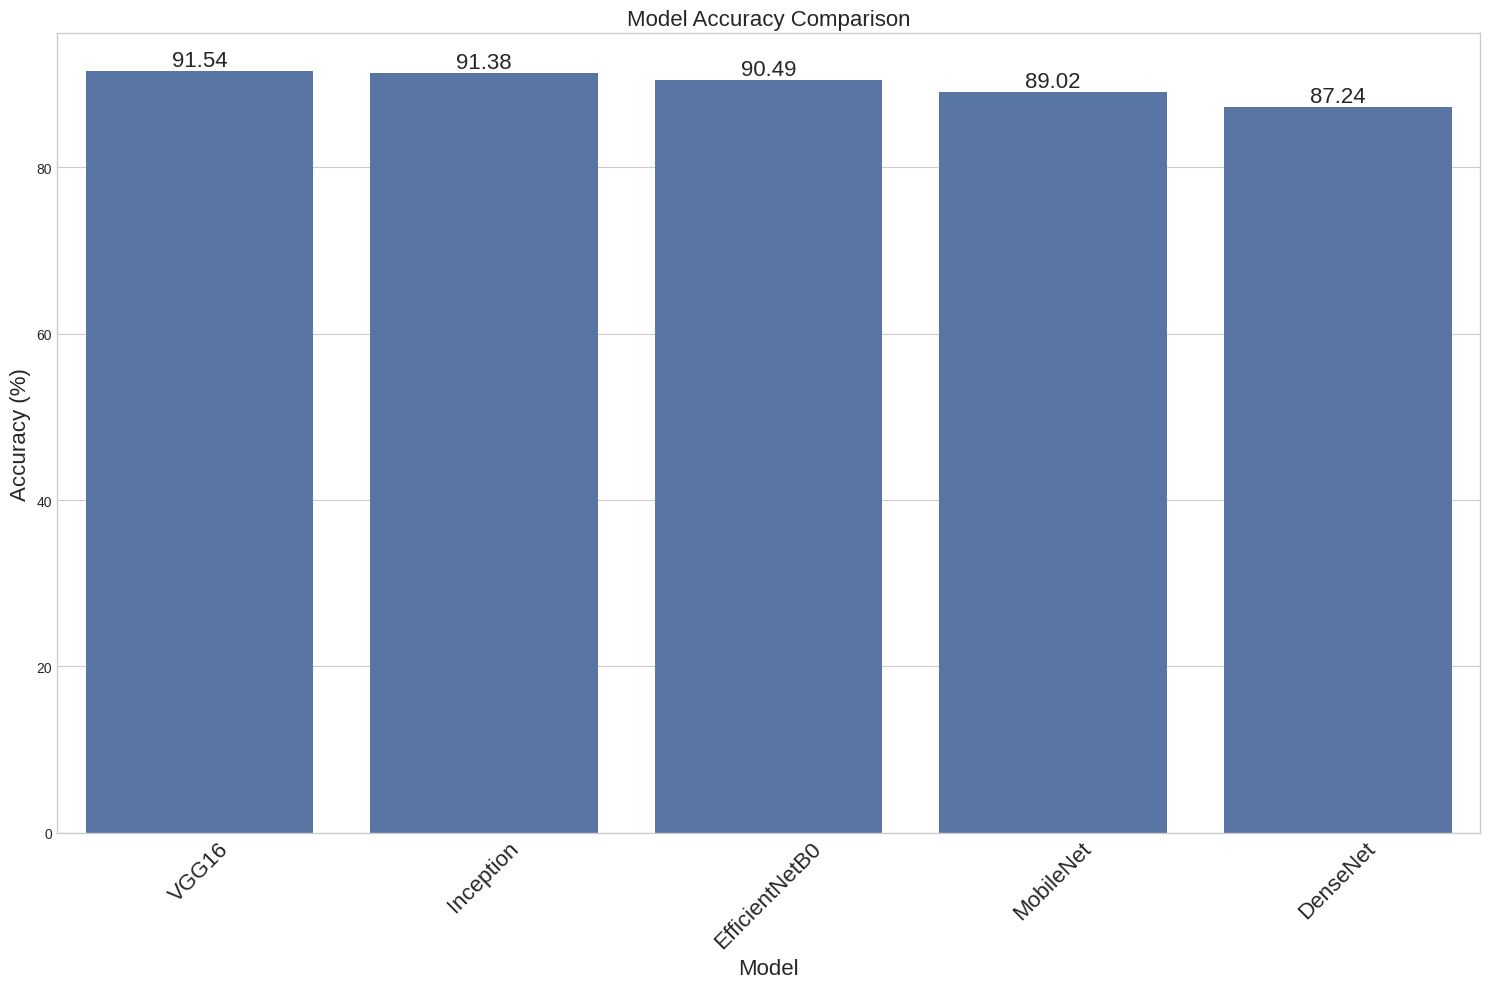

In [ ]:
plt.figure(figsize=(15, 10))  # Set figure size

ax = sns.barplot(x='model', y='accuracy (%)', data=df)

# Add labels to bars
ax.bar_label(ax.containers[0], fmt="%.2f", fontsize=16)  # Labels with 2 decimal places

# Labels and layout adjustments
plt.xlabel("Model", fontsize=16)
plt.ylabel("Accuracy (%)", fontsize=16)
plt.title("Model Accuracy Comparison", fontsize=16)
plt.xticks(rotation=45, fontsize= 16)
plt.tight_layout()
plt.show()


<h3 style="color: #9AE6B4; font-size: 18px; font-weight: 500; margin-top: 18px; padding-left: 10px; border-left: 3px solid #68D391;">
    Visualize precision, recall, f1
</h3>


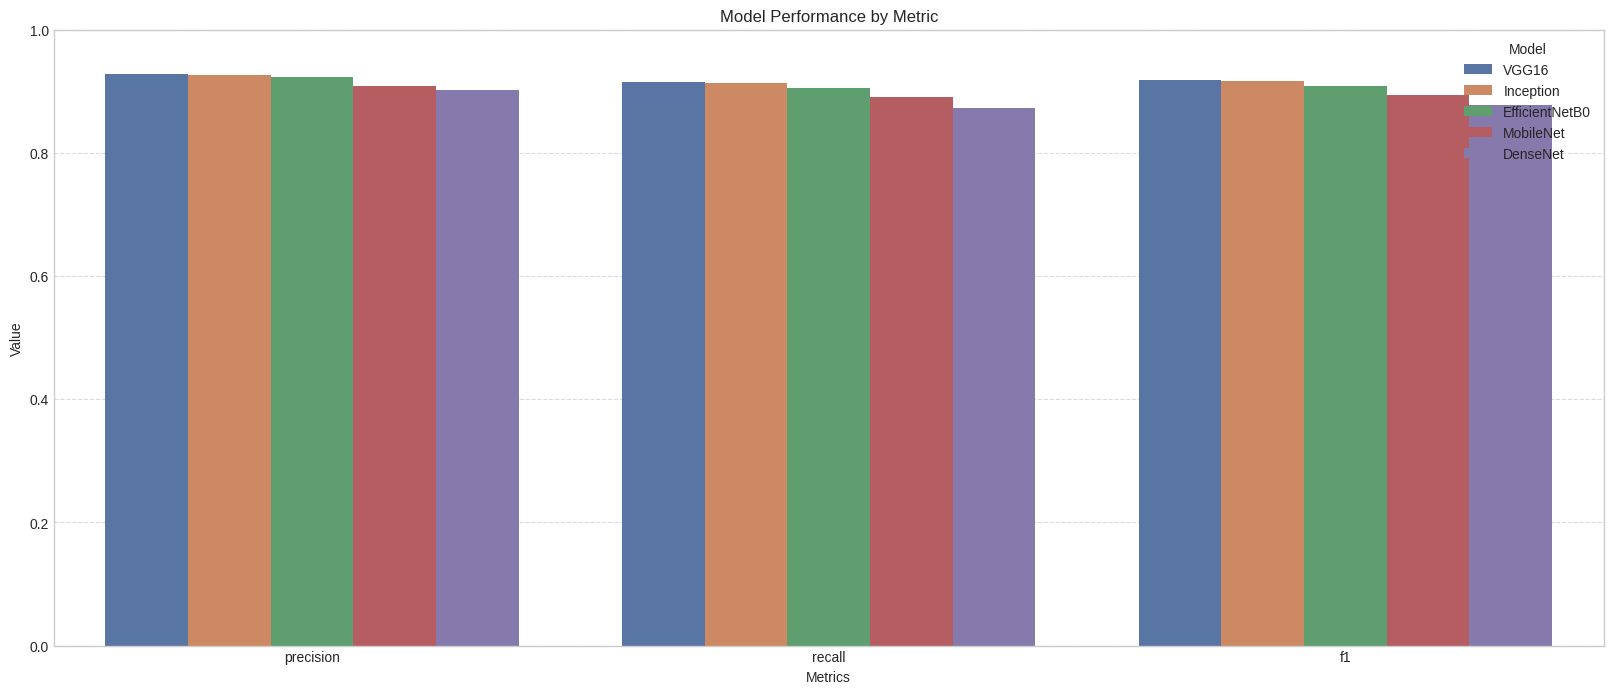

In [ ]:

df_melted = df.drop('accuracy (%)', axis= 1).melt(id_vars="model", var_name="Metric", value_name="Value")

# Bar Plot
plt.figure(figsize=(20, 8))
sns.barplot(x="Metric", y="Value", hue="model", data=df_melted)

plt.title("Model Performance by Metric")
plt.xlabel("Metrics")
plt.ylabel("Value")
plt.ylim(0, 1)
plt.legend(title="Model")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

<div style='background-color: rgba(49, 130, 206, 0.1); border-left: 4px solid #3182CE; '>
    <h2 style="background: linear-gradient(90deg, #2A4365 0%, #2C5282 100%); color: #EBF8FF; font-size: 20px; padding: 8px 12px; border-radius: 4px; margin-top: 22px; font-weight: 500;">
        5.8. Fine-Tuning best model
    </h2>

</div>


In [ ]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=1),
    ModelCheckpoint(filepath='/kaggle/working/Enhanced_model_V2.keras', monitor='val_accuracy',
                    save_best_only=True, verbose=1,mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-6, verbose=1)
]

In [ ]:
train_gen = tr_gen.flow_from_dataframe(
    train_df, x_col='name', y_col='label', target_size=IMG_SIZE,
    class_mode='categorical', color_mode='grayscale', shuffle=True, batch_size=BATCH_SIZE
)
valid_gen = ts_gen.flow_from_dataframe(
    valid_df, x_col='name', y_col='label', target_size=IMG_SIZE,
    class_mode='categorical', color_mode='grayscale', shuffle=True, batch_size=BATCH_SIZE
)
test_gen = ts_gen.flow_from_dataframe(
    test_df, x_col='name', y_col='label', target_size=IMG_SIZE,
    class_mode='categorical', color_mode='grayscale', shuffle=False, batch_size=test_batch_size
)

Found 3806 validated image filenames belonging to 2 classes.
Found 1230 validated image filenames belonging to 2 classes.
Found 820 validated image filenames belonging to 2 classes.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_99          │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,383,141 (16.72 MB)

 Trainable params: 4,338,558 (16.55 MB)

 Non-trainable params: 44,583 (174.16 KB)

Model plot saved as 'model_plot.png'
Epoch 1/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.7514 - loss: 16.7477
Epoch 1: val_accuracy improved from -inf to 0.80244, saving model to /kaggle/working/Enhanced_model_V2.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 156s 703ms/step - accuracy: 0.7518 - loss: 16.7368 - val_accuracy: 0.8024 - val_loss: 13.6819 - learning_rate: 1.0000e-04
Epoch 2/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.7839 - loss: 10.4813
Epoch 2: val_accuracy did not improve from 0.80244
119/119 ━━━━━━━━━━━━━━━━━━━━ 37s 309ms/step - accuracy: 0.7836 - loss: 10.4716 - val_accuracy: 0.5732 - val_loss: 7.4584 - learning_rate: 1.0000e-04
Epoch 3/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.6845 - loss: 7.0515
Epoch 3: val_accuracy did not improve from 0.80244
119/119 ━━━━━━━━━━━━━━━━━━━━ 36s 305ms/step - accuracy: 0.6844 - loss: 7.0484 - val_accuracy: 0.4659 - val_loss: 5.8746 - learning_rate: 1.0000e-04
Epoch 4/100
119/119 ━━━━━━━━━━━━━━━

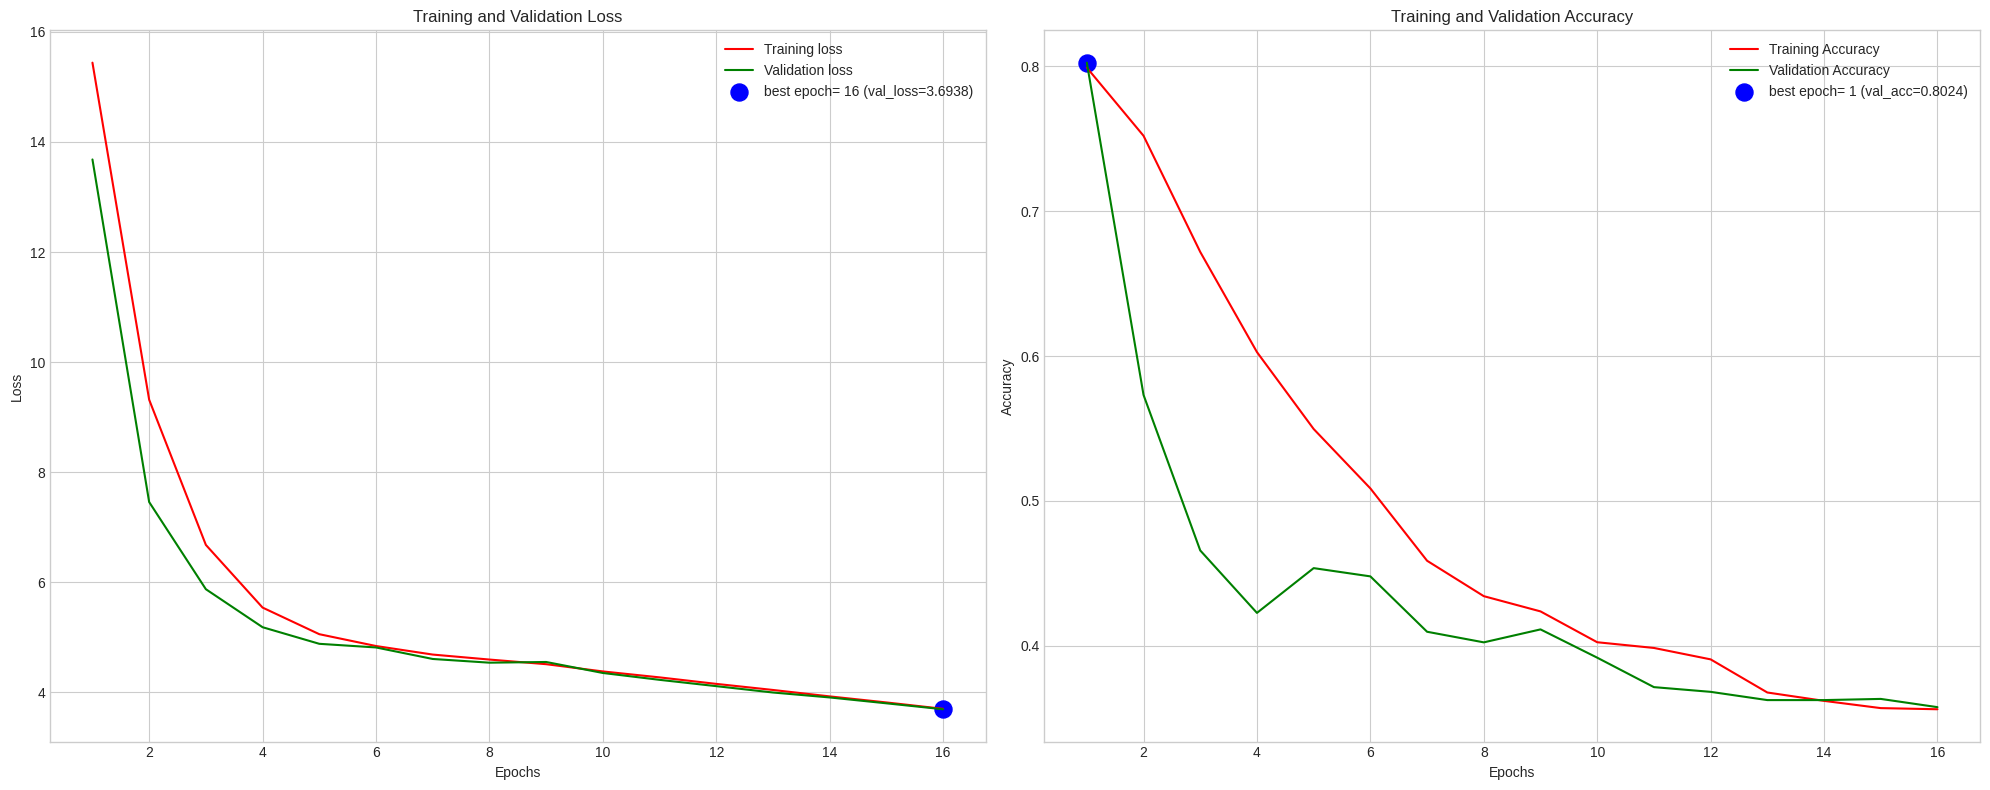

In [ ]:
model= build_custom_model(
    EfficientNetB0,
    IMG_SHAPE,
    CLASS_COUNT,
    freeze_percentage=0,
    weights="imagenet",
    pooling="max",
    learning_rate=0.0001,
    plot_file="model_plot.png"
)
# Fit with GPU (Kaggle handles GPU automatically)
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=100,
    verbose=1,
    class_weight= class_weight_dict_mapped,
    callbacks=callbacks
)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
plot_training_history(history)

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.8212 - loss: 13.7298
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.7904 - loss: 13.5537
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 284ms/step - accuracy: 0.8142 - loss: 16.5045
Train Loss:  13.648173332214355
Train Accuracy:  0.815625011920929
--------------------
Validation Loss:  13.568258285522461
Validation Accuracy:  0.7953125238418579
--------------------
Test Loss:  16.408222198486328
Test Accuracy:  0.8121951222419739


<h1 style="color: #63B3ED; font-size: 28px; font-weight: 600; padding-bottom: 8px; border-bottom: 2px solid #4299E1; margin-top: 25px;">
    6. Prediction
</h1>

<div style='background-color: rgba(49, 130, 206, 0.1); border-left: 4px solid #3182CE; '>
    <h2 style="background: linear-gradient(90deg, #2A4365 0%, #2C5282 100%); color: #EBF8FF; font-size: 20px; padding: 8px 12px; border-radius: 4px; margin-top: 22px; font-weight: 500;">
        6.1 Prediction on valid data
    </h2>
    <p style='padding-left: 20px; padding-bottom: 20px'>
</p>
</div>


39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step


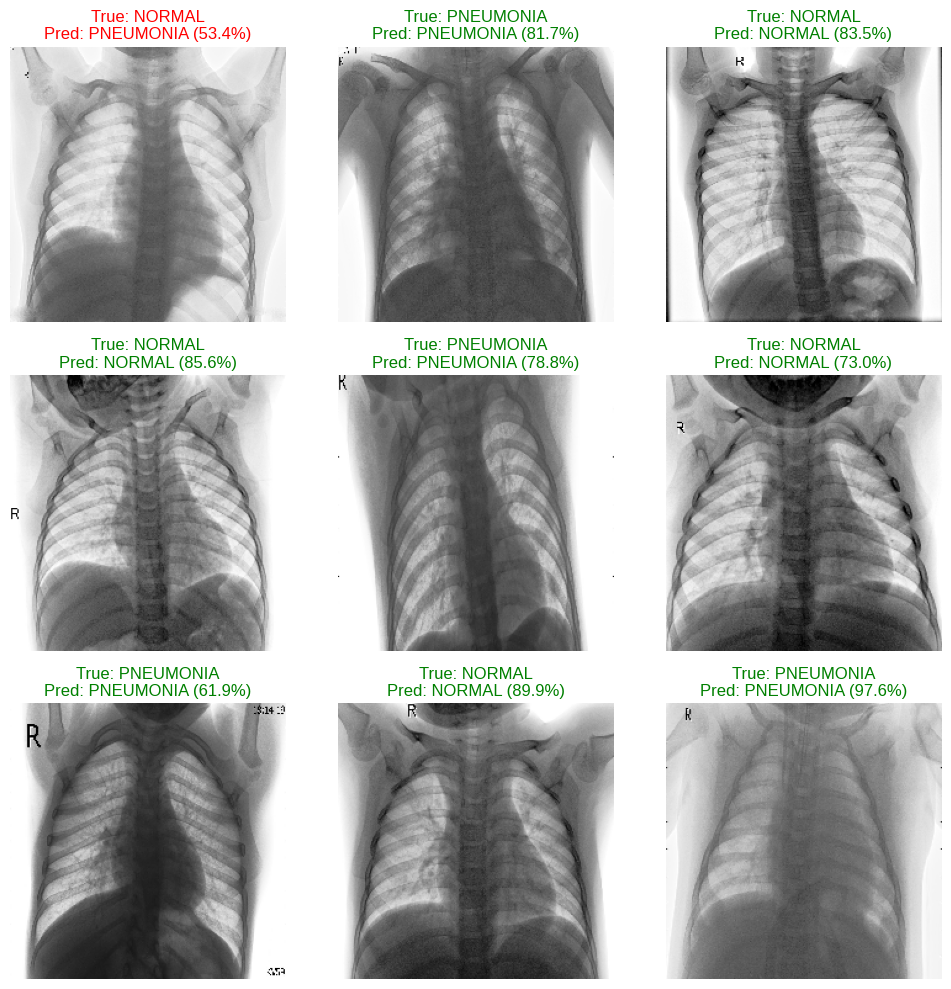

In [ ]:
# Reset generator before looping (important!)
valid_gen.reset()

# Collect all images & labels
all_images = []
all_labels = []

# Extract multiple batches
for _ in range(len(valid_gen)):  # Loop through all batches
    images, labels = next(valid_gen)
    all_images.extend(images)
    all_labels.extend(labels)

# Convert lists to numpy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Get model predictions
predictions = model.predict(all_images)

# Convert one-hot encoded labels to class indices
true_classes = np.argmax(all_labels, axis=1)
predicted_classes = np.argmax(predictions, axis=1)

# Extract class names
class_names = list(valid_gen.class_indices.keys())

# Shuffle images, labels, and predictions together
indices = np.random.permutation(len(all_images))
shuffled_images = all_images[indices]
shuffled_true_classes = true_classes[indices]
shuffled_predicted_classes = predicted_classes[indices]
shuffled_predictions = predictions[indices]  # Shuffle prediction confidence too

# Plot random images with true & predicted labels
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(shuffled_images[i])
    ax.axis("off")

    # Get labels & prediction confidence
    true_label = CLASS_NAMES[shuffled_true_classes[i]]
    pred_label = CLASS_NAMES[shuffled_predicted_classes[i]]
    confidence = 100 * np.max(shuffled_predictions[i])  # Get highest confidence

    # Set title with color
    ax.set_title(f"True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)",
                 color="green" if true_label == pred_label else "red")

plt.tight_layout()
plt.show()


<div style='background-color: rgba(49, 130, 206, 0.1); border-left: 4px solid #3182CE; '>
    <h2 style="background: linear-gradient(90deg, #2A4365 0%, #2C5282 100%); color: #EBF8FF; font-size: 20px; padding: 8px 12px; border-radius: 4px; margin-top: 22px; font-weight: 500;">
        6.2 Prediction on test data
    </h2>
    <p style='padding-left: 20px; padding-bottom: 20px'>
</p>
</div>


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 245ms/step


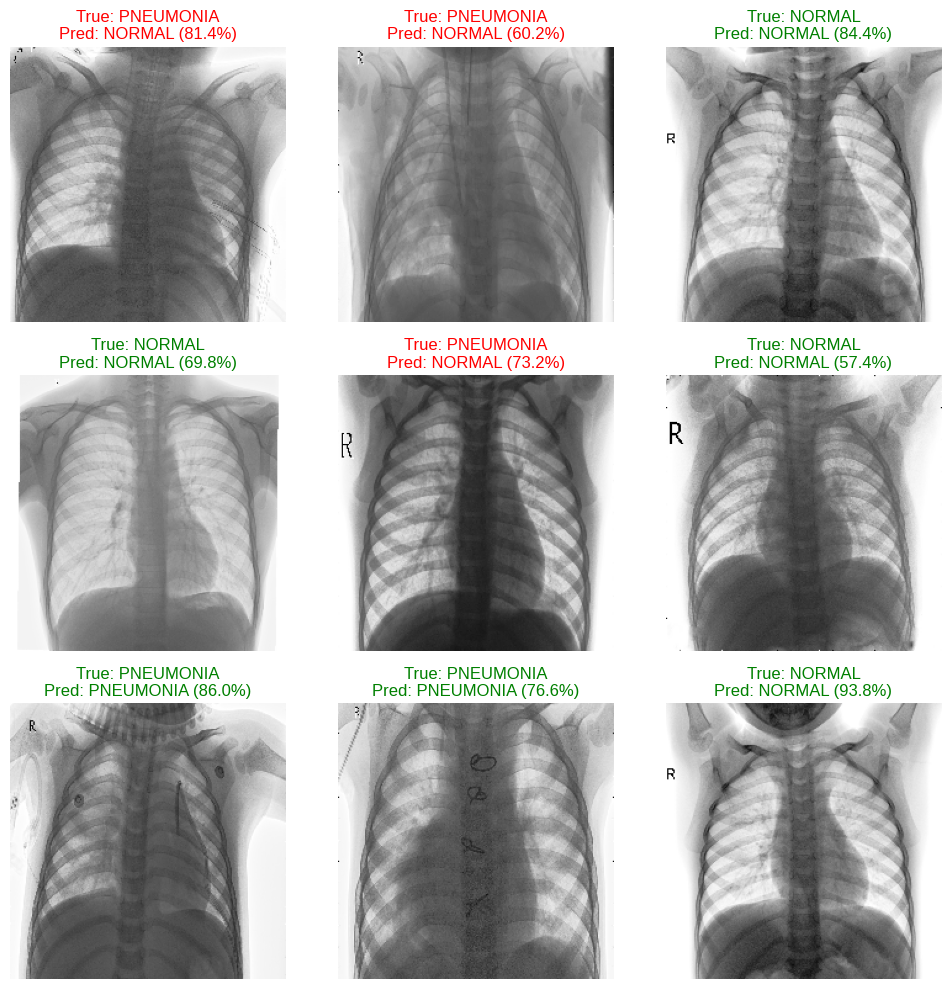

In [ ]:
# Reset generator before looping (important!)
test_gen.reset()

# Collect all images & labels
all_images = []
all_labels = []

# Extract multiple batches
for _ in range(len(test_gen)):  # Loop through all batches
    images, labels = next(test_gen)
    all_images.extend(images)
    all_labels.extend(labels)

# Convert lists to numpy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Get model predictions
predictions = model.predict(all_images)

# Convert one-hot encoded labels to class indices
true_classes = np.argmax(all_labels, axis=1)
predicted_classes = np.argmax(predictions, axis=1)

# Extract class names
class_names = list(test_gen.class_indices.keys())

# Shuffle images, labels, and predictions together
indices = np.random.permutation(len(all_images))
shuffled_images = all_images[indices]
shuffled_true_classes = true_classes[indices]
shuffled_predicted_classes = predicted_classes[indices]
shuffled_predictions = predictions[indices]  # Shuffle prediction confidence too

# Plot random images with true & predicted labels
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(shuffled_images[i])
    ax.axis("off")

    # Get labels & prediction confidence
    true_label = CLASS_NAMES[shuffled_true_classes[i]]
    pred_label = CLASS_NAMES[shuffled_predicted_classes[i]]
    confidence = 100 * np.max(shuffled_predictions[i])  # Get highest confidence

    # Set title with color
    ax.set_title(f"True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)",
                 color="green" if true_label == pred_label else "red")

plt.tight_layout()
plt.show()


<div style='background-color: rgba(49, 130, 206, 0.1); border-left: 4px solid #3182CE; '>
    <h2 style="background: linear-gradient(90deg, #2A4365 0%, #2C5282 100%); color: #EBF8FF; font-size: 20px; padding: 8px 12px; border-radius: 4px; margin-top: 22px; font-weight: 500;">
        6.3 Prediction on url image
    </h2>
    <p style='padding-left: 20px; padding-bottom: 20px'>
</p>
</div>


In [ ]:
url = "https://static.elsevier.es/multimedia/21735727/0000004600000007/v1_202206240715/S2173572722000819/v1_202206240715/en/main.assets/gr1.jpeg?idApp=WMIE"


In [ ]:
import requests
def predict_image_from_url(url):
    try:
        # تحميل الصورة من الرابط
        response = requests.get(url)
        if response.status_code != 200:
            raise ValueError("Failed to download image.")

        # تحويل الصورة إلى مصفوفة NumPy
        image_array = np.array(bytearray(response.content), dtype=np.uint8)

        # فك تشفير الصورة باستخدام OpenCV
        image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
        if image is None:
            raise ValueError("Invalid image format or corrupted image.")

        # تغيير الحجم إلى (224, 224) - يمكن تعديله حسب النموذج المستخدم
        image = cv2.resize(image, (224, 224))

        # تحويل BGR إلى RGB لأن OpenCV يقرأ الصور في BGR
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # تحويل الصورة إلى نوع `float32` وتطبيع القيم بين 0 و 1
        image = image.astype("float32") / 255.0

        # توسيع الأبعاد لتتوافق مع إدخال النموذج (batch_size, height, width, channels)
        image = np.expand_dims(image, axis=0)

        # التأكد من شكل الصورة قبل التنبؤ
        print("Processed image shape:", image.shape)  # يجب أن يكون (3, 224, 224, 1)

        # إجراء التنبؤ باستخدام النموذج
        predict_img = model.predict(image)

        # استخراج التصنيف الأكثر احتمالًا
        predict_img_label = CLASS_NAMES[np.argmax(predict_img)]

        return predict_img_label, image

    except Exception as e:
        print("Error:", str(e))
        return None


In [ ]:
predict_img_label,image= predict_image_from_url(url)

Processed image shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


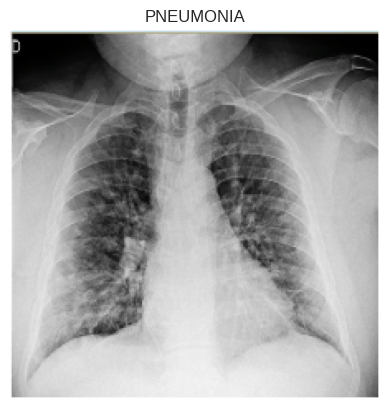

In [ ]:
# Remove batch dimension (convert from (1, 224, 224, 3) to (224, 224, 3))
image = np.squeeze(image, axis=0)
plt.imshow(image)
plt.title(predict_img_label)
plt.axis('off')
plt.show()

<div style='background-color: rgba(49, 130, 206, 0.1); border-left: 4px solid #3182CE; '>
    <h2 style="background: linear-gradient(90deg, #2A4365 0%, #2C5282 100%); color: #EBF8FF; font-size: 20px; padding: 8px 12px; border-radius: 4px; margin-top: 22px; font-weight: 500;">
       6.4 Predict on local image
    </h2>
    <p style='padding-left: 20px; padding-bottom: 20px'>
</p>
</div>


In [ ]:

CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

def predict_and_plot(img_path, model):
    """ يأخذ مسار الصورة، يعالجها بنفس طريقة التدريب، ثم يتنبأ بها ويعرض النتيجة """


    img = Image.open(img_path).convert('L')

    img_resized = img.resize((224, 224))

    img_array = img_to_array(img_resized)
    img_array = np.expand_dims(img_array, axis=0)


    if model is None:
        raise ValueError("النموذج لم يتم تحميله. تأكد من تحميله قبل استدعاء الدالة.")


    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    confidence = np.max(predictions) * 100

    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"Predicted: {CLASS_NAMES[predicted_class]} ({confidence:.1f}%)",
              color="green" if confidence > 50 else "red")
    plt.show()

    return CLASS_NAMES[predicted_class], confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


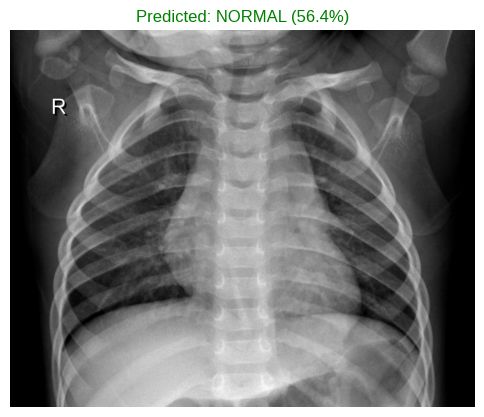

('NORMAL', np.float32(56.428345))

In [ ]:
predict_and_plot('/kaggle/input/chest-image/n2.jpeg', model)